# Web Scraping

In [1]:
from dotenv import load_dotenv
load_dotenv("dev.env")
import os

db_name = os.getenv("db_name")
db_username = os.getenv("db_username")
db_password = os.getenv("db_password")
db_host = os.getenv("db_host")
db_port = os.getenv("db_port")
website = os.getenv("website")
city_link = os.getenv("city_link")
chrome_path = os.getenv("chrome_path")
selenium_chrome_driver_path = os.getenv("selenium_chrome_driver_path")

First, we are loading environment variables, this is not required for non-professional projects but it is a good practice to hide your private variables that contains database credentials which might make your server vulnerable.

In [2]:
import psycopg2
import time
import math
import numpy as np
import os.path
import pandas as pd
import re
import pycld2
import nltk
import joblib
import warnings
import urllib.request
import io
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
import sys
import sweetviz as sv
import webbrowser
import gc
import matplotlib.image as mpimg
import shap
import seaborn as sns
from datetime import date, timedelta, datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By 
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from nltk.corpus import stopwords
from TurkishStemmer import TurkishStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor, ElasticNet, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.kernel_ridge import KernelRidge
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.metrics import accuracy_score, f1_score, precision_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from PIL import Image
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from sklearn import metrics
from sklearn.utils import shuffle
from wordcloud import WordCloud
from zemberek import TurkishSentenceNormalizer, TurkishMorphology
from threading import Timer
from scipy import stats
#from IPython.display import display, Image

nltk.download('stopwords', quiet=True)

stemmer = TurkishStemmer()

conn_string = 'host={pghost} port={pgport} dbname={pgdatabase} user={pguser} password={pgpassword}'.format(pgdatabase=db_name,pguser=db_username,pgpassword=db_password,pghost=db_host,pgport=db_port)
conn=psycopg2.connect(conn_string)
cur=conn.cursor()

options = Options()
options.binary_location = chrome_path

warnings.filterwarnings('ignore')

def check_if_table_exists(schema,table):
    cur.execute("select exists(select * from information_schema.tables where table_schema='{schema}' AND table_name='{table}')".format(schema=schema, table=table))
    return cur.fetchone()[0]

def check_if_index_exists(index):
    cur.execute("SELECT EXISTS(SELECT * FROM PG_CLASS WHERE relname = '{index}')".format(index=index))
    return cur.fetchone()[0]

def check_if_file_exists(filename):
    return os.path.isfile(filename)

def execute_mogrify(conn, df, schema, table):
    tuples = [tuple(x) for x in df.to_numpy()]
    cols = '"'+'","'.join(list(df.columns))+'"'
    cursor = conn.cursor()    
    try:
        for tup in tuples:
            query  = """INSERT INTO "{schema}"."{table}"({cols}) VALUES ({values}) ON CONFLICT DO NOTHING""".format(schema=schema,table=table, cols=cols, values=",".join(map(str,tup)))
            cursor.execute(query)
            conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    cursor.close()

def df_column_conversation(df, column_name, type):
    if(type == 'timestamp'):
        df[column_name] = df[column_name].apply(lambda x: f"'{x}'::timestamp")
    if(type == 'text'):
        df[column_name] = df[column_name].str.replace("'","").apply(lambda x: f"'{x}'")
    if(type == 'date'):
        df[column_name] = df[column_name].apply(lambda x: f"'{x}'::date")
    if(type == 'numeric'):
        df[column_name] = df[column_name].apply(str).str.replace(',','.')
    if(type == 'integer'):
        df[column_name] = df[column_name].apply(str).str.replace(',','.').apply(float).astype('Int64').apply(str)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-\\]", "", text)
    return text

def webpage_scroll_down(driver, scroll_speed):
    total_height = int(driver.execute_script("return document.body.scrollHeight"))
    for i in range(1, total_height, scroll_speed):
        driver.execute_script("window.scrollTo(0, {});".format(i))

def byte_image_to_numpy_array(byte_image, image_size):
    return cv2.resize(np.array(Image.open(io.BytesIO(byte_image))), (image_size, image_size))

def analyze_data(outputHTML,upToDateCheck,schema,table):
    if not((check_if_file_exists(outputHTML) and upToDateCheck)):
        sql_command = """
        SELECT * 
        FROM "{schema}"."{table}";
        """.format(schema=schema, table=table)
        df = pd.read_sql(sql_command,conn)

        eda = sv.analyze(df)
        eda.show_html(outputHTML, open_browser=False)
        
        del df
        gc.collect()
        #eda_sales.show_notebook()
    
    webbrowser.open(outputHTML,new=2)
    print('You can see the exploratory data analysis visualizations in your browser.')

def analyze_dataframe(outputHTML,upToDateCheck,df):
    if not((check_if_file_exists(outputHTML) and upToDateCheck)):
        eda = sv.analyze(df)
        eda.show_html(outputHTML, open_browser=False)
        
        del df
        gc.collect()
        #eda_sales.show_notebook()
    
    webbrowser.open(outputHTML,new=2)
    print('You can see the exploratory data analysis visualizations in your browser.')

def feature_importance_plot(label, model_name, feature_columns, feature_importance):
    plt.title('{label} {model_name} Feature Importance'.format(label=label.title(), model_name=model_name))
    plt.barh(feature_columns, model.feature_importances_)
    plt.tight_layout()
    plt.autoscale()
    plt.savefig('images/{label}.png'.format(label=label))
    plt.close()

def merge_images(image_paths, orientation='horizontal', background_color='WHITE'):
    if(type(image_paths[0])!=Image.Image):
        images = [Image.open(x) for x in image_paths]
    else:
        images = image_paths
    
    min_shape = sorted([(np.sum(i.size), i.size) for i in images])[0][1]
    
    if(orientation=='horizontal'):
        images_combined = np.hstack((np.asarray(i.resize(min_shape)) for i in images))
    if(orientation=='vertical'):
        images_combined = np.vstack((np.asarray(i.resize(min_shape)) for i in images))

    merged_im = Image.fromarray(images_combined)
    merged_image = merged_im
    if(background_color!=''):
        merged_image = Image.new("RGBA", merged_im.size, background_color)
        merged_image.paste(merged_im, (0, 0), merged_im)

    return merged_image

def turkish_to_english_characters(text):
    tr_en_chars = {'ı':'i', 'ğ':'g', 'İ':'I', 'Ğ':'G', 'ç':'c', 'Ç':'C', 'ş':'s', 'Ş':'S', 'ö':'o', 'Ö':'O', 'ü':'u', 'Ü':'U'}
    for tr, en in tr_en_chars.items():
        text = text.replace(tr, en)
    return text

morphology = TurkishMorphology.create_with_defaults()
normalizer = TurkishSentenceNormalizer(morphology)

def normalize_text(text, timeout=10):
    try:
        Timer(timeout, sys.exit()).start()
        return normalizer.normalize(text)
    except:
        return text

def stem_text(text):
    words = text.split()
    stemmed_words = ([stemmer.stem(word) for word in words])
    return ' '.join(stemmed_words)

def read_txt_file(location, encoding, column_names):
    with open(location, encoding=encoding) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
        return pd.DataFrame(lines, columns=column_names)

positive_words_df = read_txt_file('positive_words_tr.txt','utf-8',['WORD'])
negative_words_df = read_txt_file('negative_words_tr.txt','utf-8',['WORD'])
sentiment_words_list = pd.concat([positive_words_df, negative_words_df])['WORD'].values.tolist()
def sentiment_text(text):
    sentiment_value = 0
    try:        
        text = text.lower()
        word_list = text.split()
        for word in word_list:
            if word not in(sentiment_words_list):
                word_list.remove(word)
        for word in word_list:
            if word in positive_words_df["WORD"].values:
                sentiment_value+= 1
                text = text.replace(word, "")
            if word in negative_words_df["WORD"].values:
                sentiment_value-= 1
                text = text.replace(word, "")
    finally:
        return sentiment_value

def kstest_result(df, column_name, distribution='norm'):
    df_name = [x for x in globals() if globals()[x] is df][0]
    kstest = stats.kstest(df[column_name][pd.notnull(df[column_name])].values, distribution)
    return "Kolmogorov-Smirnov test in {df_name} for {column_name} statistic: {statistic_value:0.4f}, p value: {p_value:0.4f}".format(df_name=df_name, column_name=column_name.capitalize(), statistic_value=kstest[0], p_value=kstest[1])

def distribution_plot(df, column_name):
    df_name = [x for x in globals() if globals()[x] is df][0]
    df = df[pd.notnull(df[column_name])]
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
    mean=df[column_name].mean()
    median=df[column_name].median()
    mode=df[column_name].mode().values[0]

    sns.boxplot(data=df, x=column_name, ax=ax_box)
    ax_box.axvline(mean, color='r', linestyle='--')
    ax_box.axvline(median, color='g', linestyle='-')
    ax_box.axvline(mode, color='b', linestyle='-')

    sns.histplot(data=df, x=column_name, ax=ax_hist, kde=True)
    ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
    ax_hist.axvline(median, color='g', linestyle='-', label="Median")
    ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")

    ax_hist.legend()

    ax_box.set(xlabel='')
    plt.savefig('images/distribution_plot_{df_name}_{column_name}.png'.format(df_name=df_name, column_name=column_name))
    plt.close()

We are defining our functions and importing libraries which will be used in the next steps.

In [ ]:
if(check_if_table_exists('ODS','EXT_FB_RESTAURANT')):
    print('Table ODS.EXT_FB_RESTAURANT already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "ODS"."EXT_FB_RESTAURANT"
    (
    "RESTAURANT_ID" text NOT NULL,
    "RESTAURANT_NAME" text,
    "RESTAURANT_LINK" text,
    "DATE" date,    
    CONSTRAINT "RESTAURANT_ID" UNIQUE ("RESTAURANT_ID")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table ODS.EXT_FB_RESTAURANT created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('ODS','EXT_FB_MENU')):
    print('Table ODS.EXT_FB_MENU already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "ODS"."EXT_FB_MENU"
    (
    "PRODUCT_ID" text NOT NULL,
    "RESTAURANT_ID" text,
    "CATEGORY_NAME" text,
    "PRODUCT_NAME" text,
    "PRODUCT_DESCRIPTION" text,
    "PRODUCT_LISTED_PRICE" text,
    "PRODUCT_PRICE" text,
    "DISCOUNT" boolean,
    "DESIGN_TYPE" text,
    "DATE" date,
    CONSTRAINT "PRODUCT_ID" UNIQUE ("PRODUCT_ID")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table ODS.EXT_FB_MENU created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('ODS','EXT_FB_COMMENT')):
    print('Table ODS.EXT_FB_COMMENT already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "ODS"."EXT_FB_COMMENT"
    (
    "RESTAURANT_ID" text,
    "USERNAME" text,
    "COMMENT_TEXT" text,
    "COMMENT_DATE" text,
    "SPEED" text,
    "SERVING" text,
    "FLAVOUR" text,
    "DATE" date,
    CONSTRAINT "UNIQUE_COMMENTS" UNIQUE ("RESTAURANT_ID", "USERNAME", "COMMENT_TEXT")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table ODS.EXT_FB_COMMENT created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('ODS','EXT_FB_PRODUCT_IMAGE')):
    print('Table ODS.EXT_FB_PRODUCT_IMAGE already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "ODS"."EXT_FB_PRODUCT_IMAGE"
    (
    "PRODUCT_ID" text,
    "RESTAURANT_ID" text,
    "IMAGE_LINK" text,
    "DATE" date,
    CONSTRAINT "UNIQUE_IMAGES" UNIQUE ("PRODUCT_ID", "RESTAURANT_ID")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table ODS.EXT_FB_PRODUCT_IMAGE created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('ODS','EXT_FB_PRODUCT_IMAGE_SOURCE')):
    print('Table ODS.EXT_FB_PRODUCT_IMAGE_SOURCE already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "ODS"."EXT_FB_PRODUCT_IMAGE_SOURCE"
    (
    "IMAGE_LINK" text NOT NULL,
    "SOURCE" bytea,
    CONSTRAINT "UNIQUE_SOURCE" PRIMARY KEY ("IMAGE_LINK")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table ODS.EXT_FB_PRODUCT_IMAGE_SOURCE created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('ODS','EXT_FB_RESTAURANT_SERVICE')):
    print('Table ODS.EXT_FB_RESTAURANT_SERVICE already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute(
    """
    CREATE TABLE "ODS"."EXT_FB_RESTAURANT_SERVICE"
    (
    "RESTAURANT_ID" text NOT NULL,
    "MINIMUM_AMOUNT" text,
    "SERVICE_TIME" text,    
    "DATE" date,
    PRIMARY KEY ("RESTAURANT_ID"),
    CONSTRAINT "UNIQUE_SERVICE" UNIQUE ("RESTAURANT_ID")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table ODS.EXT_FB_RESTAURANT_SERVICE created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('EDW','DWH_FB_MENU')):
    print('Table EDW.DWH_FB_MENU already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "EDW"."DWH_FB_MENU"
    (
    "PRODUCT_ID" text NOT NULL,
    "RESTAURANT_ID" text,
    "CATEGORY_NAME" text,
    "PRODUCT_NAME" text,
    "PRODUCT_DESCRIPTION" text,
    "PRODUCT_LISTED_PRICE" numeric,
    "PRODUCT_PRICE" numeric,
    "DISCOUNT" boolean,
    "DESIGN_TYPE" text,
    "DATE" date,
    CONSTRAINT "PRODUCT_ID" UNIQUE ("PRODUCT_ID")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table EDW.DWH_FB_MENU created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('EDW','DWH_FB_COMMENT')):
    print('Table EDW.DWH_FB_COMMENT already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "EDW"."DWH_FB_COMMENT"
    (
    "RESTAURANT_ID" text,
    "USERNAME" text,
    "COMMENT_TEXT" text,
    "COMMENT_DATE" date,
    "SPEED" integer,
    "SERVING" integer,
    "FLAVOUR" integer,
    "DATE" date,
    CONSTRAINT "UNIQUE_COMMENTS" UNIQUE ("RESTAURANT_ID", "USERNAME", "COMMENT_TEXT")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table EDW.DWH_FB_COMMENT created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('EDW','DWH_FB_RESTAURANT_SERVICE')):
    print('Table EDW.DWH_FB_RESTAURANT_SERVICE already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "EDW"."DWH_FB_RESTAURANT_SERVICE"
    (
    "RESTAURANT_ID" text,
    "MINIMUM_AMOUNT" numeric,
    "MINIMUM_SERVICE_TIME" integer,
    "MAXIMUM_SERVICE_TIME" integer,
    "DATE" date,
    CONSTRAINT "UNIQUE_SERVICE" PRIMARY KEY ("RESTAURANT_ID")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table EDW.DWH_FB_RESTAURANT_SERVICE created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('EDW','DWH_FB_RESTAURANT')):
    print('Table EDW.DWH_FB_RESTAURANT already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "EDW"."DWH_FB_RESTAURANT"
    (
        "RESTAURANT_ID" text,
        "RESTAURANT_NAME" text,
        "RESTAURANT_BRAND" text,
        "RESTAURANT_DISTRICT" text,
        "RESTAURANT_STREET" text,
        "RESTAURANT_LINK" text,
        "DATE" date,
        CONSTRAINT "UNIQUE_RESTAURANT" UNIQUE ("RESTAURANT_ID")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table EDW.DWH_FB_RESTAURANT created in {execute_time} seconds.".format(execute_time=end_time-start_time))

if(check_if_table_exists('EDW','DWH_FB_COMMENT_SENTIMENT')):
    print('Table EDW.DWH_FB_COMMENT_SENTIMENT already exists.')   
else:
    start_time = math.trunc(time.time())
    cur.execute("""
    CREATE TABLE "EDW"."DWH_FB_COMMENT_SENTIMENT"
    (
        "RESTAURANT_ID" text,
        "USERNAME" text,
        "COMMENT_TEXT" text,
        "SENTIMENT_SCORE" integer,
        CONSTRAINT "UNIQUE_SENTIMENT" UNIQUE ("RESTAURANT_ID", "USERNAME", "COMMENT_TEXT")
    );
    """)
    cur.execute('COMMIT;')
    end_time = math.trunc(time.time())
    print("Table EDW.DWH_FB_COMMENT_SENTIMENT created in {execute_time} seconds.".format(execute_time=end_time-start_time))

cur.execute("""
CREATE OR REPLACE FUNCTION public.try_cast(_in text, INOUT _out anyelement)
    LANGUAGE 'plpgsql'
AS $BODY$
BEGIN
   EXECUTE format('SELECT %L::%s', $1, pg_typeof(_out))
   INTO  _out;
EXCEPTION WHEN others THEN
   -- do nothing: _out already carries default
END
$BODY$;
""")
cur.execute('COMMIT;')

Table ODS.EXT_FB_RESTAURANT already exists.
Table ODS.EXT_FB_MENU already exists.
Table ODS.EXT_FB_COMMENT already exists.
Table ODS.EXT_FB_PRODUCT_IMAGE already exists.
Table ODS.EXT_FB_PRODUCT_IMAGE_SOURCE already exists.
Table ODS.EXT_FB_RESTAURANT_SERVICE already exists.
Table EDW.DWH_FB_MENU already exists.
Table EDW.DWH_FB_COMMENT already exists.
Table EDW.DWH_FB_RESTAURANT_SERVICE already exists.
Table EDW.DWH_FB_RESTAURANT already exists.
Table EDW.DWH_FB_COMMENT_SENTIMENT already exists.


Creating tables that will contain our data and creating database functions.

In [ ]:
cur.execute("""
WITH DATES AS(
SELECT 
MAX("DATE") AS "DATE"
FROM "ODS"."EXT_FB_MENU" EFM
UNION ALL
SELECT 
MAX("DATE") AS "DATE"
FROM "ODS"."EXT_FB_COMMENT" EFC
)
SELECT 
MAX("DATE") AS "LAST_EXECUTION_DATE"
FROM DATES;
""")
last_execution_date = cur.fetchone()[0]
last_execution_date

datetime.date(2021, 6, 11)

Getting last execution dates in the tables to not import the same data we collected for performance.

In [ ]:
restaurant_list = []
end_date = min(date(2021,6,11),(date.today() - timedelta(days=1)))

driver = webdriver.Chrome(options=options, executable_path=selenium_chrome_driver_path)
if(last_execution_date < end_date):
    driver.get(city_link)
    time.sleep(5)
    for i in range(25):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
    city_restaurant_groups = driver.find_elements_by_class_name("restaurant-main-info")
    for restaurant in city_restaurant_groups:
        restaurant_name = restaurant.find_element_by_class_name("restaurant-display-name").text
        restaurant_name = restaurant_name.replace("YENİ ", "")
        restaurant_link = restaurant.find_element_by_class_name("restaurant-display-name").find_element_by_xpath(".//a").get_attribute('href')
        restaurant_id = restaurant_link.split("/")[-1]
        if(len(restaurant_link) < 2):
            continue
        restaurant_list.append([restaurant_id,restaurant_name,restaurant_link])
    restaurant_df = pd.DataFrame(restaurant_list, columns=["RESTAURANT_ID","RESTAURANT_NAME","RESTAURANT_LINK"])

    df_column_conversation(restaurant_df, 'RESTAURANT_ID', 'text')
    df_column_conversation(restaurant_df, 'RESTAURANT_NAME', 'text')
    df_column_conversation(restaurant_df, 'RESTAURANT_LINK', 'text')    
    restaurant_df['DATE'] = "'"+ datetime.strftime(date.today(), "%Y-%m-%d") + "'::date"
    execute_mogrify(conn,restaurant_df,"ODS","EXT_FB_RESTAURANT")

Scraping the website to gather restaurant lists and their links, in this part we need to scroll down to load all the restaurants.

In [ ]:
sql_command = """
    SELECT
    "RESTAURANT_ID"
    FROM "ODS"."EXT_FB_RESTAURANT" EFR
    WHERE 1=1
    AND NOT EXISTS(SELECT NULL FROM "ODS"."EXT_FB_MENU" EFM WHERE EFR."RESTAURANT_ID" = EFM."RESTAURANT_ID");
    """
restaurant_df = pd.read_sql(sql_command,conn)

In [ ]:
if(last_execution_date < end_date):
    for i in range(len(restaurant_df)):
        sublink = restaurant_df.loc[i,"RESTAURANT_ID"]
        restaurant_link = "{website}/{sublink}".format(website=website,sublink=sublink)
        
        driver.get(restaurant_link)
        time.sleep(5)

        try:
            if("sipariş verebilirsiniz." in driver.find_element_by_xpath('//*[@id="restaurantDetail"]/div/div[2]/h3').text):
                continue
            else:
                pass
        except Exception:
            pass
        
        menu = driver.find_element_by_xpath('//*[@id="restaurant_menu"]')
        categories = menu.find_elements_by_xpath('//*[contains(@id,"menu_")]')

        menu_list = []

        for category in categories:
            category_name = category.find_element_by_xpath(".//b").text
            for product in category.find_elements_by_xpath(".//div[2]/ul/li"):
                try:
                    design_type = "list"
                    try:
                        product_id = product.find_elements_by_class_name("getProductDetail")[-1].get_attribute('data-product-id')
                        product_name = product.find_elements_by_class_name("getProductDetail")[-1].text
                    except:
                        product_id = product.find_element_by_xpath(".//strong").get_attribute('data-product-id')
                        product_name = product.find_element_by_xpath(".//strong").text
                        design_type = "card"
                    try:
                        product_description = product.find_element_by_class_name("product-desc").text
                        product_price = product.find_element_by_class_name("price").text    
                    except:
                        product_description = product.find_element_by_class_name("productInfo").text
                        product_price = product.find_element_by_class_name("newPrice").text
                        if(not(design_type=="card")):
                            design_type = "box"
                    discount = "TRUE"
                    try:              
                        if(design_type=="list"):
                            product_listed_price = product.find_element_by_class_name("listed-price").text
                        if(design_type in ["card","box"]):
                            product_listed_price = product.find_element_by_class_name("listedPrice").text
                    except:
                        product_listed_price = product_price
                        discount = "FALSE"
                    menu_list.append([product_id,sublink,category_name,product_name,product_description,product_listed_price,product_price,discount,design_type])
                except:
                    continue
        menu_df = pd.DataFrame(menu_list, columns=["PRODUCT_ID","RESTAURANT_ID","CATEGORY_NAME","PRODUCT_NAME","PRODUCT_DESCRIPTION","PRODUCT_LISTED_PRICE","PRODUCT_PRICE","DISCOUNT","DESIGN_TYPE"])    
        menu_df = menu_df[menu_df['PRODUCT_ID'].str.len() > 0]
        menu_df = menu_df[menu_df['PRODUCT_NAME'].str.len() > 0]

        df_column_conversation(menu_df, 'PRODUCT_ID', 'text')
        df_column_conversation(menu_df, 'RESTAURANT_ID', 'text')
        df_column_conversation(menu_df, 'CATEGORY_NAME', 'text')
        df_column_conversation(menu_df, 'PRODUCT_NAME', 'text')
        df_column_conversation(menu_df, 'PRODUCT_DESCRIPTION', 'text')
        df_column_conversation(menu_df, 'PRODUCT_LISTED_PRICE', 'text')
        df_column_conversation(menu_df, 'PRODUCT_PRICE', 'text')
        df_column_conversation(menu_df, 'DESIGN_TYPE', 'text')
        menu_df['DATE'] = "'"+ datetime.strftime(date.today(), "%Y-%m-%d") + "'::date"
        execute_mogrify(conn,menu_df,"ODS","EXT_FB_MENU")
    menu_df

Looping through all of the restaurants and scraping their products.

In [ ]:
sql_command = """
    SELECT
    "RESTAURANT_ID"
    FROM "ODS"."EXT_FB_RESTAURANT" EFR
    WHERE 1=1
    AND NOT EXISTS(SELECT NULL FROM "ODS"."EXT_FB_COMMENT" EFC WHERE EFR."RESTAURANT_ID" = EFC."RESTAURANT_ID");
    """
restaurant_df = pd.read_sql(sql_command,conn)
restaurant_df = restaurant_df.sample(frac=1)
restaurant_df

RESTAURANT_ID
24         afili-pizza-kadikoy-rasimpasa-mah-istanbul
35     boysan-pizza-esenyurt-mehtercesme-mah-istanbul
67      peggys-pizza-eyup-gokturk-merkez-mah-istanbul
74                  patio-besiktas-bebek-mah-istanbul
1           pizzeria-eyup-gokturk-merkez-mah-istanbul
..                                                ...
19           atawich-esenyurt-cumhuriyet-mah-istanbul
58           ghost-pizza-sisli-tesvikiye-mah-istanbul
51              al-ye-kadikoy-dumlupinar-mah-istanbul
18  ekin-pide-lahmacun-maltepe-altaycesme-mah-ista...
55  guler-restaurant-fatih-kalenderhane-mah-sehzad...

[79 rows x 1 columns]

In [ ]:
if(last_execution_date < end_date):
    for i in range(len(restaurant_df)):
        sublink = restaurant_df.loc[i,"RESTAURANT_ID"]
        last_comment_page_url = "{website}/{sublink}?section=comments&page=9999".format(website=website,sublink=sublink)
        
        driver.get(last_comment_page_url)
        time.sleep(0.1)

        comments_list = []
        
        if(sublink not in driver.current_url):
            continue

        last_comment_page_redirect_url = driver.current_url
        last_comment_page_number = int(last_comment_page_redirect_url.replace("&status=closed","").replace("{website}/{sublink}?section=comments&page=".format(website=website,sublink=sublink),""))

        for page_number in range(1, last_comment_page_number+1):
            current_comment_page_url = "{website}/{sublink}?section=comments&page={page_number}".format(website=website,sublink=sublink,page_number=page_number)
            driver.get(current_comment_page_url)
            time.sleep(1)

            try:
                if("sipariş verebilirsiniz." in driver.find_element_by_xpath('//*[@id="restaurantDetail"]/div/div[2]/h3').text):
                    continue
                else:
                    pass
            except Exception:
                pass

            try:
                driver.find_element(By.XPATH, '//*[@id="alternative-restaurant-popup"]/div[1]/div[2]/img').click(); #Closing pop-up
            except Exception:
                pass   

            #driver.find_element(By.XPATH, '//*[@id="restaurantDetail"]/div[2]/div[1]/ul/li[4]/a').click(); #Clicking comments

            comment_list = driver.find_elements_by_class_name("comments-body")
        
            for comment in comment_list:
                try:
                    username = comment.find_element_by_class_name("userName").text
                    comment_text = comment.find_element_by_xpath('.//p').text
                    comment_date = comment.find_element_by_class_name("commentDate").text
                except NoSuchElementException:
                    continue
                try:
                    speed = comment.find_element_by_class_name("speed").text
                except NoSuchElementException:
                    speed = ""
                try:                    
                    serving = comment.find_element_by_class_name("serving").text
                except NoSuchElementException:
                    serving = ""
                try:
                    flavour = comment.find_element_by_class_name("flavour").text 
                except NoSuchElementException:
                    flavour = ""
                comments_list.append([sublink, username, comment_text, comment_date, speed, serving, flavour])
        comment_df = pd.DataFrame(comments_list, columns=["RESTAURANT_ID","USERNAME","COMMENT_TEXT","COMMENT_DATE","SPEED","SERVING","FLAVOUR"])
        df_column_conversation(comment_df, 'RESTAURANT_ID', 'text')
        df_column_conversation(comment_df, 'USERNAME', 'text')
        df_column_conversation(comment_df, 'COMMENT_TEXT', 'text')
        df_column_conversation(comment_df, 'COMMENT_DATE', 'text')
        df_column_conversation(comment_df, 'SPEED', 'text')
        df_column_conversation(comment_df, 'SERVING', 'text')
        df_column_conversation(comment_df, 'FLAVOUR', 'text')
        comment_df['DATE'] = "'"+ datetime.strftime(date.today(), "%Y-%m-%d") + "'::date"
        execute_mogrify(conn,comment_df,"ODS","EXT_FB_COMMENT")
    comment_df

Looping through all of the restaurants and scraping their reviews and given scores for each comment.

In [ ]:
sql_command = """
    SELECT DISTINCT 
    "RESTAURANT_ID",
    "DESIGN_TYPE"
    FROM "ODS"."EXT_FB_MENU" EFM
    WHERE 1=1
    AND EFM."DESIGN_TYPE" <> 'list'
    AND NOT EXISTS(SELECT NULL FROM "ODS"."EXT_FB_PRODUCT_IMAGE" EFPI WHERE EFM."RESTAURANT_ID" = EFPI."RESTAURANT_ID");
    """
restaurant_df = pd.read_sql(sql_command,conn)
restaurant_df

RESTAURANT_ID DESIGN_TYPE
0     the-boss-pizza-burger-sariyer-maden-mah-istanbul        card
1            444-pizza-bagcilar-demirkapi-mah-istanbul        card
2    mezzaluna-paket-beykoz-acarlar-mah-acarkent-is...        card
3    kafein-plus-kucukcekmece-tevfikbey-mah-sefakoy...        card
4                   mayk-cafe-sisli-fulya-mah-istanbul        card
..                                                 ...         ...
208  amigos-burger-pizza-kagithane-merkez-mah-istanbul        card
209            konak-firin-avcilar-merkez-mah-istanbul        card
210  keyifle-pide-lahmacun-bakirkoy-atakoy-6-kisim-...        card
211           havelka-kadikoy-caddebostan-mah-istanbul        card
212            heros-pizza-esenyurt-fatih-mah-istanbul        card

[213 rows x 2 columns]

In [ ]:
if(last_execution_date < end_date):
    for i in range(len(restaurant_df)):
        sublink = restaurant_df.loc[i,"RESTAURANT_ID"]
        design_type = restaurant_df.loc[i,"DESIGN_TYPE"]
        page_url = "{website}/{sublink}".format(website=website,sublink=sublink)

        driver.get(page_url)
        time.sleep(0.1)
        
        webpage_scroll_down(driver, 15)

        if(sublink not in driver.current_url):
                continue

        try:
            if("sipariş verebilirsiniz." in driver.find_element_by_xpath('//*[@id="restaurantDetail"]/div/div[2]/h3').text):
                continue
            else:
                pass
        except Exception:
            pass

        try:
            driver.find_element(By.XPATH, '//*[@id="alternative-restaurant-popup"]/div[1]/div[2]/img').click(); #Closing pop-up
        except Exception:
            pass

        menu = driver.find_element_by_xpath('//*[@id="restaurant_menu"]')
        categories = menu.find_elements_by_xpath('//*[contains(@id,"menu_")]')

        image_list = []

        for product in menu.find_elements_by_class_name("product-image"):
            try:
                product_id = product.get_attribute('data-product-id')
                image_link = product.find_element_by_xpath(".//img").get_attribute('src')
                if("www.yemeksepeti.com/assets/images/" in image_link):
                    continue
                image_list.append([product_id,sublink,image_link])
            except:
                pass
        image_df = pd.DataFrame(image_list, columns=["PRODUCT_ID","RESTAURANT_ID","IMAGE_LINK"])
        df_column_conversation(image_df, 'PRODUCT_ID', 'text')
        df_column_conversation(image_df, 'RESTAURANT_ID', 'text')
        df_column_conversation(image_df, 'IMAGE_LINK', 'text')    
        image_df['DATE'] = "'"+ datetime.strftime(date.today(), "%Y-%m-%d") + "'::date"
        execute_mogrify(conn,image_df,"ODS","EXT_FB_PRODUCT_IMAGE")

In [ ]:
sql_command = """
    SELECT DISTINCT 
    "RESTAURANT_ID"
    FROM "ODS"."EXT_FB_MENU" EFM
    WHERE 1=1
    AND NOT EXISTS(SELECT NULL FROM "ODS"."EXT_FB_RESTAURANT_SERVICE" EFRS WHERE EFM."RESTAURANT_ID" = EFRS."RESTAURANT_ID");
    """
restaurant_df = pd.read_sql(sql_command,conn)
restaurant_df

RESTAURANT_ID
0   adrians-pizza-sultanbeyli-mehmet-akif-mah-ista...
1          afili-pizza-kadikoy-rasimpasa-mah-istanbul
2   antica-pizzeria-by-antica-locanda-besiktas-arn...
3           aron-pizza-atasehir-barbaros-mah-istanbul
4   ayicik-pizza-tatli-besiktas-dikilitas-mah-ista...
5            baca-pizzeria-sariyer-maden-mah-istanbul
6           balcoon-cafe-uskudar-kisikli-mah-istanbul
7            bee-pizza-esenler-davutpasa-mah-istanbul
8     big-slice-pizza-maltepe-baglarbasi-mah-istanbul
9           duses-pizza-esenyurt-ucevler-mah-istanbul
10   emporio-pizza-pasta-besiktas-levent-mah-istanbul
11  f-chef-italiano-pizza-pasta-sisli-halaskargazi...
12            hamurkeyf-fatih-cerrahpasa-mah-istanbul
13        heros-pizza-besiktas-dikilitas-mah-istanbul
14  little-caesars-pizza-bayrampasa-yenidogan-mah-...
15    little-caesars-pizza-fatih-aksaray-mah-istanbul
16    little-caesars-pizza-sariyer-maden-mah-istanbul
17         mandalin-mercan-tuzla-postane-mah-istanbul
18  mistic-pizza-burger-cafe-esenler-havaalani-mah...
19        panda-pizza-esenyurt-guzelyurt-mah-istanbul
20  pastavicio-makarna-pizza-kadikoy-caferaga-mah-...
21     pizza-bulls-sultangazi-ugur-mumcu-mah-istanbul
22       pizza-hays-cafe-pendik-velibaba-mah-istanbul
23     pizza-hut-atasehir-kucukbakkalkoy-mah-istanbul
24            pizza-hut-besiktas-levazim-mah-istanbul
25    pizza-hut-pendik-yenisehir-mah-kurtkoy-istanbul
26  pizza-hut-sariyer-ayazaga-mah-vadi-istanbul-bo...
27      pizza-hut-sisli-esentepe-mah-ozdilek-istanbul
28    pizza-station-kagithane-seyrantepe-mah-istanbul
29          pizzeria-eyup-gokturk-merkez-mah-istanbul
30  sbarro-pizza-atasehir-kucukbakkalkoy-mah-istanbul
31        sbarro-pizza-bakirkoy-osmaniye-mah-istanbul
32   sbarro-pizza-basaksehir-ziya-gokalp-mah-istanbul
33       sbarro-pizza-esenyurt-guzelyurt-mah-istanbul
34       sbarro-pizza-esenyurt-incirtepe-mah-istanbul
35      sbarro-pizza-esenyurt-saadetdere-mah-istanbul
36         sbarro-pizza-eyup-aksemsettin-mah-istanbul
37            sbarro-pizza-eyup-topcular-mah-istanbul
38         sbarro-pizza-pendik-guzelyali-mah-istanbul
39  sbarro-pizza-sisli-esentepe-mah-plazalar-istanbul
40        sbarro-pizza-umraniye-madenler-mah-istanbul
41      sbarro-pizza-umraniye-yamanevler-mah-istanbul
42      sbarro-pizza-uskudar-mimar-sinan-mah-istanbul
43  sehremini-tas-firini-fatih-sehremini-mah-capa-...
44  sembol-pasta-pide-pizza-esenler-menderes-mah-i...
45  torcello-ristorante-italiano-besiktas-akat-mah...

In [ ]:
#if(last_execution_date < end_date):
if(last_execution_date < end_date):
    for i in range(len(restaurant_df)):
        sublink = restaurant_df.loc[i,"RESTAURANT_ID"]
        restaurant_link = "{website}/{sublink}".format(website=website,sublink=sublink)
        
        driver.get(restaurant_link)
        time.sleep(5)

        try:
            if("sipariş verebilirsiniz." in driver.find_element_by_xpath('//*[@id="restaurantDetail"]/div/div[2]/h3').text):
                continue
            else:
                pass
        except Exception:
            pass

        minimum_amount = ""
        service_time = ""
        for shortInfoItem in driver.find_elements_by_class_name('shortInfoItem'):
            if("Min. Tutar" in shortInfoItem.text):
                minimum_amount = shortInfoItem.text.replace("Min. Tutar\n","").replace(" TL", "").replace(",",".")
            if("Servis Süresi" in shortInfoItem.text):
                service_time = shortInfoItem.text.replace("Servis Süresi\n","").replace(" dk.", "")
        if(minimum_amount == "" and service_time == ""):
            continue
        service_df = pd.DataFrame([[sublink, minimum_amount, service_time]], columns=["RESTAURANT_ID","MINIMUM_AMOUNT","SERVICE_TIME"])
        df_column_conversation(service_df, 'RESTAURANT_ID', 'text')
        df_column_conversation(service_df, 'MINIMUM_AMOUNT', 'text')
        df_column_conversation(service_df, 'SERVICE_TIME', 'text')
        service_df['DATE'] = "'"+ datetime.strftime(date.today(), "%Y-%m-%d") + "'::date"
        execute_mogrify(conn,service_df,"ODS","EXT_FB_RESTAURANT_SERVICE")

In [ ]:
driver.quit()

In [ ]:
sql_command = """
    SELECT DISTINCT
    "IMAGE_LINK"
    FROM "ODS"."EXT_FB_PRODUCT_IMAGE" EFPI
    WHERE 1=1
    AND NOT EXISTS(SELECT NULL FROM "ODS"."EXT_FB_PRODUCT_IMAGE_SOURCE" EFPIS WHERE EFPIS."IMAGE_LINK" = EFPI."IMAGE_LINK");
    """
image_df = pd.read_sql(sql_command,conn)
image_df = image_df.sample(frac=1).reset_index(drop=True)
image_df

IMAGE_LINK
0  https://cdn.yemeksepeti.com/ProductImages/TR_I...

In [ ]:
for i in range(len(image_df)):
    page_url = image_df.loc[i,"IMAGE_LINK"]
    image_file_name = "images/product.jpg"
    try:
        urllib.request.urlretrieve(page_url, image_file_name)
    except:
        continue
    image_binary = psycopg2.Binary(open(image_file_name, 'rb').read())
    cur.execute("""
    INSERT INTO "ODS"."EXT_FB_PRODUCT_IMAGE_SOURCE" ("IMAGE_LINK","SOURCE") 
    VALUES('{image_link}',{image_binary})
    ON CONFLICT DO NOTHING;
    """.format(image_link=page_url, image_binary=image_binary))
    cur.execute('COMMIT;')

Looping through all of the restaurants and scraping their product images for deep learning purposes.

# Data Preprocessing

In [ ]:
cur.execute("""
INSERT INTO "EDW"."DWH_FB_MENU"
SELECT 
EFM."PRODUCT_ID",
EFM."RESTAURANT_ID",
EFM."CATEGORY_NAME",
EFM."PRODUCT_NAME",
EFM."PRODUCT_DESCRIPTION",
REPLACE(REPLACE(EFM."PRODUCT_LISTED_PRICE",' TL',''),',','.')::numeric AS "PRODUCT_LISTED_PRICE",
REPLACE(REPLACE(EFM."PRODUCT_PRICE",' TL',''),',','.')::numeric AS "PRODUCT_PRICE",
EFM."DISCOUNT",
EFM."DESIGN_TYPE",
EFM."DATE"
FROM "ODS"."EXT_FB_MENU" EFM

ON CONFLICT DO NOTHING;
""")
cur.execute('COMMIT;')

In [ ]:
cur.execute("""
INSERT INTO "EDW"."DWH_FB_RESTAURANT_SERVICE"
SELECT
EFRS."RESTAURANT_ID",
EFRS."MINIMUM_AMOUNT"::numeric AS "MINIMUM_AMOUNT",
LEFT(EFRS."SERVICE_TIME", STRPOS(EFRS."SERVICE_TIME", '-')-1)::integer AS "MINIMUM_SERVICE_TIME",
RIGHT(EFRS."SERVICE_TIME", STRPOS(EFRS."SERVICE_TIME", '-')-1)::integer AS "MAXIMUM_SERVICE_TIME",
EFRS."DATE"
FROM "ODS"."EXT_FB_RESTAURANT_SERVICE" EFRS

ON CONFLICT DO NOTHING;
""")
cur.execute('COMMIT;')

In [ ]:
cur.execute("""
INSERT INTO "EDW"."DWH_FB_RESTAURANT"
WITH STREET AS(
SELECT 
EFR."RESTAURANT_ID",
EFR."RESTAURANT_NAME",
SUBSTRING(EFR."RESTAURANT_NAME", '\((.+)\)') AS "RESTAURANT_STREET",
EFR."RESTAURANT_LINK",
EFR."DATE" 
FROM "ODS"."EXT_FB_RESTAURANT" EFR
)
SELECT
EFR."RESTAURANT_ID",
EFR."RESTAURANT_NAME",
SPLIT_PART(REPLACE(REPLACE(REPLACE(EFR."RESTAURANT_NAME",COALESCE(EFR."RESTAURANT_STREET",''),''),'(',''),')',''),',',1) AS "RESTAURANT_BRAND",
REVERSE(SPLIT_PART(REVERSE(REPLACE(REPLACE(REPLACE(EFR."RESTAURANT_NAME",COALESCE(EFR."RESTAURANT_STREET",''),''),'(',''),')','')),',',1)) AS "RESTAURANT_DISTRICT",
EFR."RESTAURANT_STREET",
EFR."RESTAURANT_LINK",
EFR."DATE"
FROM STREET EFR

ON CONFLICT DO NOTHING;
""")
cur.execute('COMMIT;')

In [ ]:
if(last_execution_date < end_date):
    sql_command = """
        WITH CLEAN_DATA AS(
        SELECT
        EFC."RESTAURANT_ID",
        EFC."USERNAME",
        LOWER(EFC."COMMENT_TEXT") AS "COMMENT_TEXT",
        EFC."COMMENT_DATE",
        TRY_CAST(REGEXP_REPLACE(EFC."SPEED", '\D','','g'),NULL::INTEGER) AS "SPEED",
        TRY_CAST(REGEXP_REPLACE(EFC."SERVING", '\D','','g'),NULL::INTEGER) AS "SERVING",
        TRY_CAST(REGEXP_REPLACE(EFC."FLAVOUR", '\D','','g'),NULL::INTEGER) AS "FLAVOUR",
        EFC."DATE",
        REGEXP_REPLACE(EFC."COMMENT_DATE", '\D','','g')||' '||REPLACE(REPLACE(REPLACE(REGEXP_REPLACE(REPLACE(EFC."COMMENT_DATE",' önce',''), '[^[:alpha:]]', '', 'g'),'ay','month'),'bugün','today'),'gün','day') AS "COMMENT_DATE_INTERVAL"
        FROM "ODS"."EXT_FB_COMMENT" EFC
        WHERE 1=1
        AND EFC."USERNAME" <> 'Yemeksepeti'
        )
        SELECT
        CD."RESTAURANT_ID",
        CD."USERNAME",
        CD."COMMENT_TEXT",
        CASE WHEN CD."COMMENT_DATE_INTERVAL" = ' today' THEN CD."DATE" ELSE CD."DATE" - CAST(CD."COMMENT_DATE_INTERVAL" AS INTERVAL) END::date AS "COMMENT_DATE",
        CD."SPEED",
        CD."SERVING",
        CD."FLAVOUR",
        CD."DATE"
        FROM CLEAN_DATA CD;
        """
    comment_df = pd.read_sql(sql_command,conn)
    comment_df['COMMENT_TEXT'] = comment_df['COMMENT_TEXT'].apply(clean_text)
    comment_df
    df_column_conversation(comment_df, 'RESTAURANT_ID', 'text')
    df_column_conversation(comment_df, 'USERNAME', 'text')
    df_column_conversation(comment_df, 'COMMENT_TEXT', 'text')
    df_column_conversation(comment_df, 'COMMENT_DATE', 'date')
    df_column_conversation(comment_df, 'SPEED', 'integer')
    df_column_conversation(comment_df, 'SERVING', 'integer')
    df_column_conversation(comment_df, 'FLAVOUR', 'integer')
    df_column_conversation(comment_df, 'DATE', 'date')
    comment_df.replace('<NA>', 'NULL', inplace=True)
    execute_mogrify(conn,comment_df,"EDW","DWH_FB_COMMENT")

In [ ]:
sql_command = """
    SELECT
    EFR."RESTAURANT_ID",
    EFR."USERNAME",
    EFR."COMMENT_TEXT",
    EFR."COMMENT_DATE",
    EFR."SPEED",
    CASE WHEN EFR."SPEED" > (AVG(EFR."SPEED") OVER()) THEN 'True' ELSE 'False' END AS "ABOVE_AVERAGE_SPEED",
    EFR."SERVING",
    CASE WHEN EFR."SERVING" > (AVG(EFR."SERVING") OVER()) THEN 'True' ELSE 'False' END AS "ABOVE_AVERAGE_SERVING",
    EFR."FLAVOUR",
    CASE WHEN EFR."FLAVOUR" > (AVG(EFR."FLAVOUR") OVER()) THEN 'True' ELSE 'False' END AS "ABOVE_AVERAGE_FLAVOUR",
    EFR."DATE"
    FROM "EDW"."DWH_FB_COMMENT" EFR;
    """
comment_df = pd.read_sql(sql_command,conn)
comment_df

RESTAURANT_ID USERNAME  \
0       pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...o   
1       pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...n   
2       pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...t   
3       pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...n   
4       pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...1   
...                                                ...      ...   
271838  pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...5   
271839  pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...i   
271840  pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...2   
271841  pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...n   
271842  pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...5   

                                             COMMENT_TEXT COMMENT_DATE  SPEED  \
0              herzamanki gibi mükemmel ellerinize saglik   2021-05-26   10.0   
1       favori pizzacım genelde madness söylüyordum yo...   2021-05-25   10.0   
2                     şahane şimdi tekrarlıyorum siparişi   2021-05-25   10.0   
3                                hamur seçimi yapılamıyor   2021-05-24   10.0   
4       pizza kesilmeden gönderilmişti lütfen dikkat e...   2021-05-24   10.0   
...                                                   ...          ...    ...   
271838                        elinize sağlık çok başarılı   2021-05-27   10.0   
271839                                              super   2021-05-27   10.0   
271840  pizzadan anlamayanların beğendiği bir pizza do...   2021-05-27   10.0   
271841                   cok guzeldi bu sefer tesekkurler   2021-05-26   10.0   
271842  hawaii pizza ve yarı yarıya pizzalar harika in...   2021-05-26   10.0   

       ABOVE_AVERAGE_SPEED  SERVING ABOVE_AVERAGE_SERVING  FLAVOUR  \
0                     True       10                  True       10   
1                     True       10                  True       10   
2                     True       10                  True       10   
3                     True        9                  True        7   
4                     True        8                 False       10   
...                    ...      ...                   ...      ...   
271838                True       10                  True       10   
271839                True       10                  True       10   
271840                True        5                 False        5   
271841                True       10                  True       10   
271842                True       10                  True       10   

       ABOVE_AVERAGE_FLAVOUR        DATE  
0                       True  2021-06-09  
1                       True  2021-06-09  
2                       True  2021-06-09  
3                      False  2021-06-09  
4                       True  2021-06-09  
...                      ...         ...  
271838                  True  2021-06-09  
271839                  True  2021-06-09  
271840                 False  2021-06-09  
271841                  True  2021-06-09  
271842                  True  2021-06-09  

[271843 rows x 11 columns]

In [ ]:
sql_command = """
    WITH AVERAGE_SCORES AS(
    SELECT 
    DFC."RESTAURANT_ID",
    AVG(DFC."SPEED") AS "SPEED",
    AVG(DFC."SERVING") AS "SERVING",
    AVG(DFC."FLAVOUR") AS "FLAVOUR"
    FROM "EDW"."DWH_FB_COMMENT" DFC
    WHERE 1=1
    AND DFC."SPEED" IS NOT NULL
    GROUP BY DFC."RESTAURANT_ID"
    HAVING COUNT(*) >= 30
    ),
    MENU AS(
    SELECT 
    EFM."RESTAURANT_ID",
    COUNT(*) AS "PRODUCT_COUNT",
    SUM(CASE WHEN LOWER(EFM."CATEGORY_NAME") LIKE '%pizza%' OR LOWER(EFM."PRODUCT_NAME") LIKE '%pizza%' OR LOWER(EFM."PRODUCT_DESCRIPTION") LIKE '%pizza%' THEN 1 ELSE 0 END) AS "PIZZA_COUNT",
    AVG(CASE WHEN LOWER(EFM."CATEGORY_NAME") LIKE '%pizza%' OR LOWER(EFM."PRODUCT_NAME") LIKE '%pizza%' OR LOWER(EFM."PRODUCT_DESCRIPTION") LIKE '%pizza%' THEN EFM."PRODUCT_LISTED_PRICE" ELSE NULL END) AS "AVERAGE_PIZZA_PRICE",
    AVG(CASE WHEN EFM."DISCOUNT" THEN 1 ELSE 0 END) AS "DISCOUNT_RATIO"
    FROM "EDW"."DWH_FB_MENU" EFM
    WHERE 1=1
    AND LOWER("CATEGORY_NAME") NOT LIKE '%çecek%'
    AND LOWER("CATEGORY_NAME") NOT LIKE '%poşet%'
    AND LOWER("CATEGORY_NAME") NOT LIKE '%soslar%'
    AND LOWER("CATEGORY_NAME") NOT LIKE '%kahve%'
    AND LOWER("CATEGORY_NAME") NOT LIKE '%çay%'
    GROUP BY EFM."RESTAURANT_ID"
    ),
    SENTIMENT AS(
    SELECT
    DFCS."RESTAURANT_ID",
    SUM(DFCS."SENTIMENT_SCORE") AS "TOTAL_SENTIMENT_SCORE",
    CASE WHEN SUM(DFCS."SENTIMENT_SCORE") = 0 THEN 0 ELSE AVG(DFCS."SENTIMENT_SCORE") END AS "AVERAGE_SENTIMENT_SCORE",
    CASE WHEN STDDEV(DFCS."SENTIMENT_SCORE") IS NULL THEN 0 ELSE STDDEV(DFCS."SENTIMENT_SCORE") END AS "STD_SENTIMENT_SCORE"
    FROM "EDW"."DWH_FB_COMMENT_SENTIMENT" DFCS
    GROUP BY DFCS."RESTAURANT_ID"
    )
    SELECT
    DFR."RESTAURANT_ID",
    DFR."RESTAURANT_BRAND",
    DFR."RESTAURANT_DISTRICT",
    DFR."RESTAURANT_STREET",
    DFRS."MINIMUM_AMOUNT",
    DFRS."MINIMUM_SERVICE_TIME",
    DFRS."MAXIMUM_SERVICE_TIME",
    (DFRS."MAXIMUM_SERVICE_TIME"+DFRS."MINIMUM_SERVICE_TIME")/2 AS "EXPECTED_SERVICE_TIME",
    SQRT(POWER(DFRS."MAXIMUM_SERVICE_TIME"-DFRS."MINIMUM_SERVICE_TIME",2)/12) AS "STD_SERVICE_TIME",
    (SQRT(POWER(DFRS."MAXIMUM_SERVICE_TIME"-DFRS."MINIMUM_SERVICE_TIME",2)/12))/((DFRS."MAXIMUM_SERVICE_TIME"+DFRS."MINIMUM_SERVICE_TIME")/2) AS "COV_SERVICE_TIME",
    MENU."PRODUCT_COUNT",
    MENU."PIZZA_COUNT",
    MENU."AVERAGE_PIZZA_PRICE",
    MENU."DISCOUNT_RATIO",
    SNT."TOTAL_SENTIMENT_SCORE",
    SNT."AVERAGE_SENTIMENT_SCORE",
    SNT."STD_SENTIMENT_SCORE",
    AVS."SPEED",
    AVS."SERVING",
    AVS."FLAVOUR"
    FROM "EDW"."DWH_FB_RESTAURANT" DFR
    INNER JOIN "EDW"."DWH_FB_RESTAURANT_SERVICE" DFRS ON (DFR."RESTAURANT_ID" = DFRS."RESTAURANT_ID")
    INNER JOIN AVERAGE_SCORES AVS ON (DFR."RESTAURANT_ID" = AVS."RESTAURANT_ID")
    INNER JOIN MENU ON (DFR."RESTAURANT_ID" = MENU."RESTAURANT_ID" AND MENU."PIZZA_COUNT" > 0)
    INNER JOIN SENTIMENT SNT ON (DFR."RESTAURANT_ID"= SNT."RESTAURANT_ID");
    """
service_df = pd.read_sql(sql_command,conn)
service_df

RESTAURANT_ID  \
0    1991-tarihi-ortakoy-kumpircisi-silivri-yeni-ma...   
1             400-c-pizza-sisli-tesvikiye-mah-istanbul   
2           400-c-pizza-umraniye-serifali-mah-istanbul   
3            444-pizza-bagcilar-demirkapi-mah-istanbul   
4              444-pizza-eyup-emniyettepe-mah-istanbul   
..                                                 ...   
865  yummy-pizza-beylikduzu-adnan-kahveci-mah-istanbul   
866           yummy-pizza-pendik-esenyali-mah-istanbul   
867  yuz-seksen-gram-pizza-umraniye-ataturk-mah-ist...   
868  zi-burger-pizza-basaksehir-bahcesehir-2-kisim-...   
869    zucca-pizza-sisli-bozkurt-mah-kurtulus-istanbul   

                   RESTAURANT_BRAND RESTAURANT_DISTRICT  \
0    1991 Tarihi Ortaköy Kumpircisi            Silivri    
1                      400° C Pizza              Şişli    
2                      400° C Pizza           Ümraniye    
3                         444 Pizza           Bağcılar    
4                         444 Pizza               Eyüp    
..                              ...                 ...   
865                     Yummy Pizza         Beylikdüzü    
866                     Yummy Pizza             Pendik    
867           Yüz Seksen Gram Pizza           Ümraniye    
868               Zi Burger & Pizza         Başakşehir    
869                     Zucca Pizza              Şişli    

            RESTAURANT_STREET  MINIMUM_AMOUNT  MINIMUM_SERVICE_TIME  \
0                   Yeni Mah.            30.0                    20   
1              Teşvikiye Mah.             0.0                    35   
2               Şerifali Mah.             5.0                    30   
3              Demirkapı Mah.             0.0                    35   
4            Emniyettepe Mah.            14.9                    20   
..                        ...             ...                   ...   
865        Adnan Kahveci Mah.            20.0                    30   
866             Esenyalı Mah.             5.0                    50   
867              Atatürk Mah.             5.0                    20   
868  Bahçeşehir 2. Kısım Mah.            35.0                    35   
869   Bozkurt Mah. - Kurtuluş             5.0                    20   

     MAXIMUM_SERVICE_TIME  EXPECTED_SERVICE_TIME  STD_SERVICE_TIME  \
0                      30                     25          2.886751   
1                      45                     40          2.886751   
2                      40                     35          2.886751   
3                      45                     40          2.886751   
4                      30                     25          2.886751   
..                    ...                    ...               ...   
865                    40                     35          2.886751   
866                    60                     55          2.886751   
867                    30                     25          2.886751   
868                    45                     40          2.886751   
869                    30                     25          2.886751   

     COV_SERVICE_TIME  PRODUCT_COUNT  PIZZA_COUNT  AVERAGE_PIZZA_PRICE  \
0            0.115470             45           10            41.600000   
1            0.072169             53           48            63.645833   
2            0.082479             43           43            65.232558   
3            0.072169             62           40            42.382500   
4            0.115470             75           47            43.553191   
..                ...            ...          ...                  ...   
865          0.082479             54           49            37.508163   
866          0.052486             31           31            24.190323   
867          0.115470             21           20            35.350000   
868          0.072169             46           28            43.035714   
869          0.115470             64           32            62.281250   

     DISCOUNT_RATIO  TOTAL_SENTIMENT_SCORE  AVERAGE_

In [ ]:
stop_words = [element for element in stopwords.words('turkish') if element not in ['çok','eğer','gibi','hiç','niçin','niye','sanki','yani','en','az','birkaç','bazı','aslında','neden','hepsi']]
comment_df['COMMENT_TEXT'] = comment_df['COMMENT_TEXT'].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in (stop_words)]))
#comment_df['COMMENT_TEXT'] = comment_df['COMMENT_TEXT'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
comment_df

RESTAURANT_ID USERNAME  \
0       pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...o   
1       pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...n   
2       pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...t   
3       pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...n   
4       pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...1   
...                                                ...      ...   
271838  pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...5   
271839  pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...i   
271840  pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...2   
271841  pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...n   
271842  pizza-hot-slice-cekmekoy-tasdelen-mah-istanbul     ...5   

                                             COMMENT_TEXT COMMENT_DATE  SPEED  \
0              herzamanki gibi mükemmel ellerinize saglik   2021-05-26   10.0   
1       favori pizzacım genelde madness söylüyordum yo...   2021-05-25   10.0   
2                     şahane şimdi tekrarlıyorum siparişi   2021-05-25   10.0   
3                                hamur seçimi yapılamıyor   2021-05-24   10.0   
4       pizza kesilmeden gönderilmişti lütfen dikkat e...   2021-05-24   10.0   
...                                                   ...          ...    ...   
271838                        elinize sağlık çok başarılı   2021-05-27   10.0   
271839                                              super   2021-05-27   10.0   
271840  pizzadan anlamayanların beğendiği bir pizza do...   2021-05-27   10.0   
271841                      cok guzeldi sefer tesekkurler   2021-05-26   10.0   
271842  hawaii pizza yarı yarıya pizzalar harika incec...   2021-05-26   10.0   

       ABOVE_AVERAGE_SPEED  SERVING ABOVE_AVERAGE_SERVING  FLAVOUR  \
0                     True       10                  True       10   
1                     True       10                  True       10   
2                     True       10                  True       10   
3                     True        9                  True        7   
4                     True        8                 False       10   
...                    ...      ...                   ...      ...   
271838                True       10                  True       10   
271839                True       10                  True       10   
271840                True        5                 False        5   
271841                True       10                  True       10   
271842                True       10                  True       10   

       ABOVE_AVERAGE_FLAVOUR        DATE  
0                       True  2021-06-09  
1                       True  2021-06-09  
2                       True  2021-06-09  
3                      False  2021-06-09  
4                       True  2021-06-09  
...                      ...         ...  
271838                  True  2021-06-09  
271839                  True  2021-06-09  
271840                 False  2021-06-09  
271841                  True  2021-06-09  
271842                  True  2021-06-09  

[271843 rows x 11 columns]

Cleaning our review dataset with lowercasing all the text, removing punctuations, removing some Turkish stopwords, and estimating when the reviews are made, we are also transforming string scores to the integer type.

In [ ]:
sql_command = """
    SELECT 
    DFC."RESTAURANT_ID",
    DFC."USERNAME",
    DFC."COMMENT_TEXT" 
    FROM "EDW"."DWH_FB_COMMENT" DFC
    WHERE 1=1
    AND NOT EXISTS(SELECT NULL FROM "EDW"."DWH_FB_COMMENT_SENTIMENT" DFCS WHERE DFC."RESTAURANT_ID" = DFCS."RESTAURANT_ID" AND DFC."USERNAME" = DFCS."USERNAME" AND DFC."COMMENT_TEXT" = DFCS."COMMENT_TEXT");
    """
sentiment_pre_df = pd.read_sql(sql_command,conn)

rows_per_loop = 100
end_row = len(sentiment_pre_df)+1 
for i in range(0, end_row, rows_per_loop):
    start_time = math.trunc(time.time())
    sentiment_df = sentiment_pre_df[i: i+rows_per_loop]
    sentiment_df['SENTIMENT_SCORE'] = sentiment_df['COMMENT_TEXT'].apply(normalize_text).apply(sentiment_text)
    df_column_conversation(sentiment_df, 'RESTAURANT_ID', 'text')
    df_column_conversation(sentiment_df, 'USERNAME', 'text')
    df_column_conversation(sentiment_df, 'COMMENT_TEXT', 'text')
    execute_mogrify(conn,sentiment_df,"EDW","DWH_FB_COMMENT_SENTIMENT")    
    end_time = math.trunc(time.time())
    print("Inserted rows between {starting_row} and {ending_row} ({rows_per_loop} rows) in {execute_time} seconds.".format(execute_time=end_time-start_time, starting_row=len(sentiment_df), ending_row=i+rows_per_loop, rows_per_loop=rows_per_loop))

Inserted rows between 0 and 100 (100 rows) in 0 seconds.


# Exploratory Data Analysis

In [ ]:
analyze_data('eda_restaurant.html',False,'ODS','EXT_FB_RESTAURANT')
analyze_data('eda_menu.html',False,'EDW','DWH_FB_MENU')
analyze_data('eda_product_image.html',False,'ODS','EXT_FB_PRODUCT_IMAGE')
analyze_data('eda_comment.html',False,'EDW','DWH_FB_COMMENT')
analyze_dataframe('eda_service.html',False,service_df[['MINIMUM_AMOUNT','MINIMUM_SERVICE_TIME','MAXIMUM_SERVICE_TIME','EXPECTED_SERVICE_TIME','STD_SERVICE_TIME','COV_SERVICE_TIME','PRODUCT_COUNT','PIZZA_COUNT','AVERAGE_PIZZA_PRICE','DISCOUNT_RATIO','TOTAL_SENTIMENT_SCORE','AVERAGE_SENTIMENT_SCORE','STD_SENTIMENT_SCORE','SPEED','SERVING','FLAVOUR']])

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report eda_restaurant.html was generated.
You can see the exploratory data analysis visualizations in your browser.


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report eda_menu.html was generated.
You can see the exploratory data analysis visualizations in your browser.


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report eda_product_image.html was generated.
You can see the exploratory data analysis visualizations in your browser.


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report eda_comment.html was generated.
You can see the exploratory data analysis visualizations in your browser.


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report eda_service.html was generated.
You can see the exploratory data analysis visualizations in your browser.


We have 1,189 distinct resturants, 131,131 distinct products with 1,077 distinct categories and 23,109 dstinct names only 11% of the products are discounted. 

Our product prices are averaging around 41 with 30.4 standart deviation. We have around 5,112 product images.

In user reviews we have 271,843 comments which 221,312 of them are distinct in user scores most of the user scores are 10 with around 56-64% of the scores and the second most common score is 1 with around 10-13% of the scores.

Dataset does not contain any missing data except in user speed scores which contains less than 1% of the data with 3,495 rows.

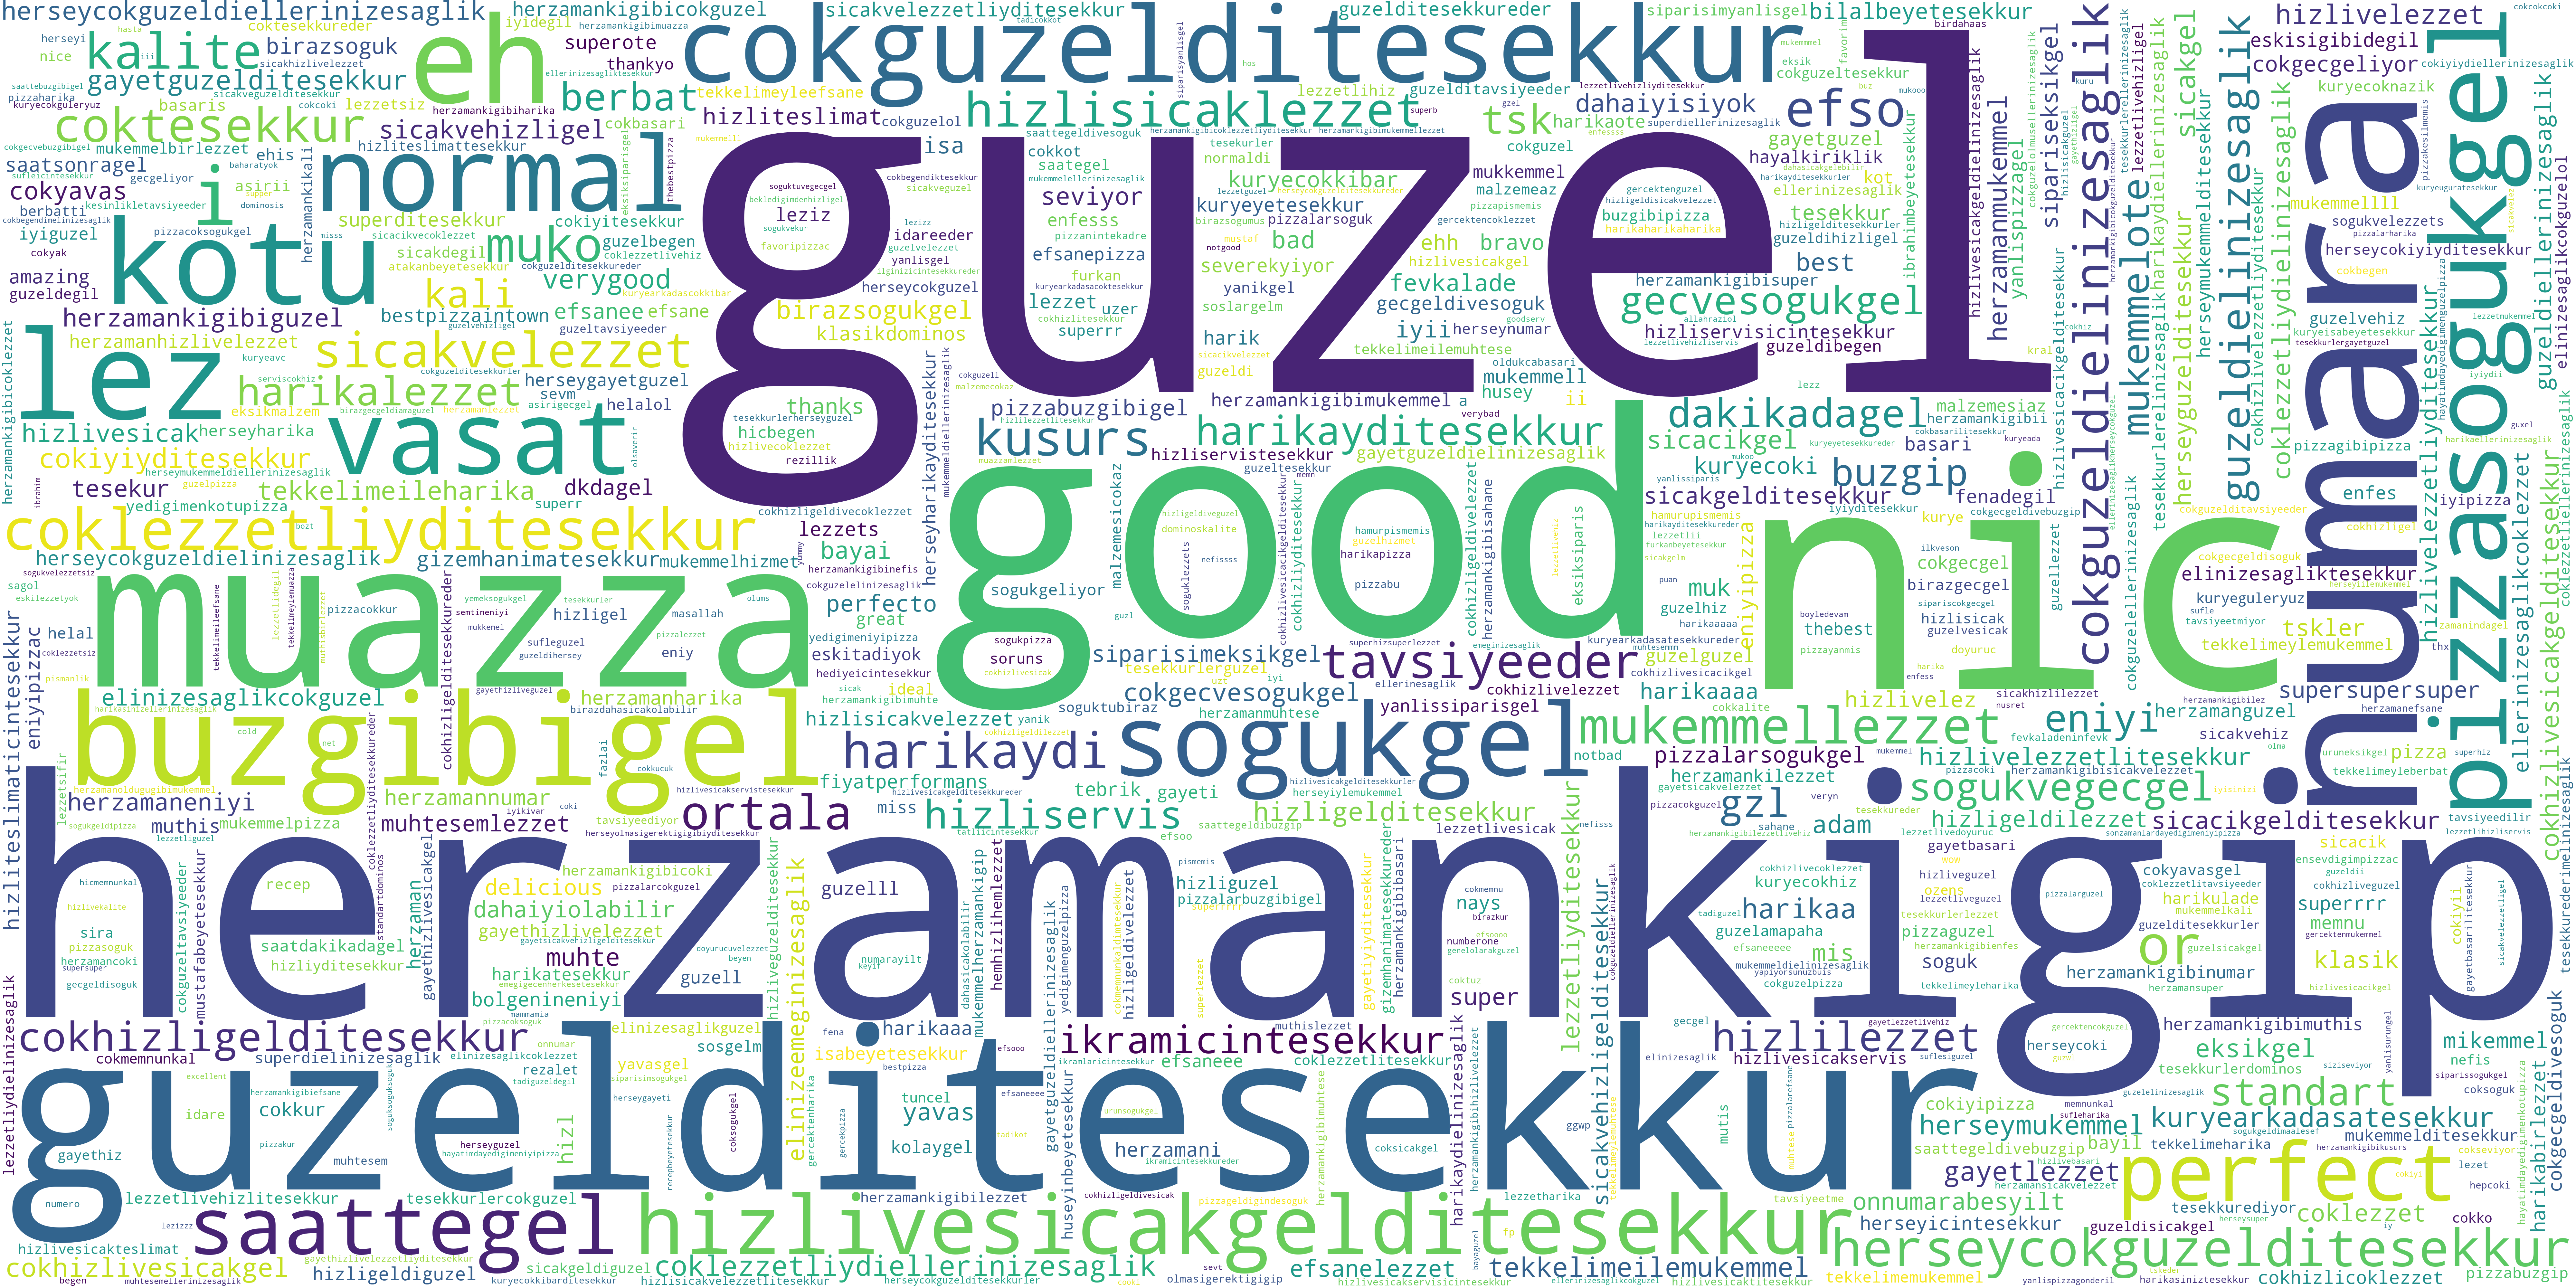

In [26]:
if(not(check_if_file_exists('images/word_cloud_popular_words.png'))):
    sql_command = """
    WITH WORDS AS(
    SELECT 
    regexp_split_to_table(regexp_replace("COMMENT_TEXT", '[^[:alpha:]]', '', 'g'), '\s+(\w\s+)*') AS "WORD"
    FROM "EDW"."DWH_FB_COMMENT"
    )
    SELECT
    "WORD",
    COUNT(*) AS "WORD_COUNT" 
    FROM WORDS
    WHERE LENGTH("WORD") > 1
    GROUP BY WORDS."WORD"
    ORDER BY COUNT(*) DESC
    LIMIT 1000;
    """
    df_word_cloud = pd.read_sql(sql_command,conn)
    df_word_cloud['WORD'] = df_word_cloud['WORD'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
    #df_word_cloud['WORD'] = df_word_cloud['WORD'].apply(normalize_text)
    df_word_cloud['WORD'] = df_word_cloud['WORD'].apply(turkish_to_english_characters)
    df_word_cloud.groupby(['WORD'], as_index=False)['WORD_COUNT'].sum()

    word_cloud_data = dict(zip(df_word_cloud['WORD'].tolist(), df_word_cloud['WORD_COUNT'].tolist()))

    wc = WordCloud(background_color='white', width=8000, height=4000, max_words=10000).generate_from_frequencies(word_cloud_data)
    wc.to_file('images/word_cloud_popular_words.png')
Image.open('images/word_cloud_popular_words.png')

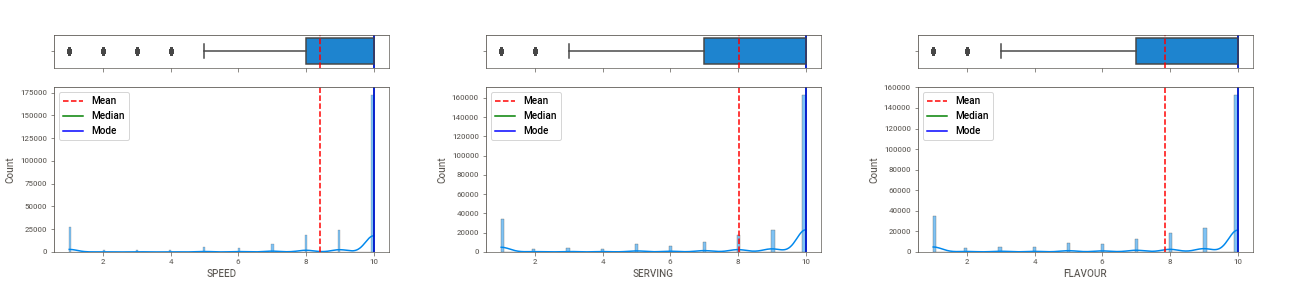

In [27]:
for label in ['SPEED', 'SERVING', 'FLAVOUR']:
    distribution_plot(comment_df, label)
merge_images(['images/distribution_plot_comment_df_SPEED.png','images/distribution_plot_comment_df_SERVING.png','images/distribution_plot_comment_df_FLAVOUR.png'], background_color='WHITE')

In [28]:
for label in ['SPEED', 'SERVING', 'FLAVOUR']:
    print(kstest_result(comment_df,label))

Kolmogorov-Smirnov test in ___ for Speed statistic: 0.8896, p value: 0.0000
Kolmogorov-Smirnov test in ___ for Serving statistic: 0.8606, p value: 0.0000
Kolmogorov-Smirnov test in ___ for Flavour statistic: 0.8562, p value: 0.0000


# Machine Learning

## Bag of Words with CountVectorizer

We are going to transform our reviews with CountVectorizer, process is similar to one-hot encoding which counts how many of these words appear in a label.

### Gaussian Naive Bayes

In [29]:
for label in ['SPEED','SERVING','FLAVOUR','ABOVE_AVERAGE_SPEED','ABOVE_AVERAGE_SERVING','ABOVE_AVERAGE_FLAVOUR']:
    model = CountVectorizer(min_df=3)
    not_null_df = comment_df[0:10000][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/BoW_CountVectorizer_GaussianNB_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = GaussianNB()
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 3526
Accuracy Score for SPEED: 33.73%
F1 Score for SPEED: 33.73%
Precision Score for SPEED: 33.73%

Total Features after vectorizing: 3526
Accuracy Score for SERVING: 29.20%
F1 Score for SERVING: 29.20%
Precision Score for SERVING: 29.20%

Total Features after vectorizing: 3526
Accuracy Score for FLAVOUR: 28.80%
F1 Score for FLAVOUR: 28.80%
Precision Score for FLAVOUR: 28.80%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_SPEED: 47.57%
F1 Score for ABOVE_AVERAGE_SPEED: 47.57%
Precision Score for ABOVE_AVERAGE_SPEED: 47.57%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_SERVING: 47.50%
F1 Score for ABOVE_AVERAGE_SERVING: 47.50%
Precision Score for ABOVE_AVERAGE_SERVING: 47.50%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_FLAVOUR: 49.37%
F1 Score for ABOVE_AVERAGE_FLAVOUR: 49.37%
Precision Score for ABOVE_AVERAGE_FLAVOUR: 49.37%



### Support Vector Machines

#### C-Support Vector Classification

In [30]:
for label in ['SPEED','SERVING','FLAVOUR','ABOVE_AVERAGE_SPEED','ABOVE_AVERAGE_SERVING','ABOVE_AVERAGE_FLAVOUR']:
    model = CountVectorizer(min_df=3)
    not_null_df = comment_df[0:10000][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)

    model_file_name = "models/BoW_CountVectorizer_SVC_{label}.mdl".format(label = label)

    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = SVC()
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 3526
Accuracy Score for SPEED: 71.87%
F1 Score for SPEED: 71.87%
Precision Score for SPEED: 71.87%

Total Features after vectorizing: 3526
Accuracy Score for SERVING: 67.30%
F1 Score for SERVING: 67.30%
Precision Score for SERVING: 67.30%

Total Features after vectorizing: 3526
Accuracy Score for FLAVOUR: 64.90%
F1 Score for FLAVOUR: 64.90%
Precision Score for FLAVOUR: 64.90%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_SPEED: 84.53%
F1 Score for ABOVE_AVERAGE_SPEED: 84.53%
Precision Score for ABOVE_AVERAGE_SPEED: 84.53%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_SERVING: 83.63%
F1 Score for ABOVE_AVERAGE_SERVING: 83.63%
Precision Score for ABOVE_AVERAGE_SERVING: 83.63%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_FLAVOUR: 85.93%
F1 Score for ABOVE_AVERAGE_FLAVOUR: 85.93%
Precision Score for ABOVE_AVERAGE_FLAVOUR: 85.93%



#### Linear Support Vector Classification

In [31]:
for label in ['SPEED','SERVING','FLAVOUR','ABOVE_AVERAGE_SPEED','ABOVE_AVERAGE_SERVING','ABOVE_AVERAGE_FLAVOUR']:
    model = CountVectorizer(min_df=3)
    not_null_df = comment_df[0:10000][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)

    model_file_name = "models/BoW_CountVectorizer_LinearSVC_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = LinearSVC()
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 3526
Accuracy Score for SPEED: 68.13%
F1 Score for SPEED: 68.13%
Precision Score for SPEED: 68.13%

Total Features after vectorizing: 3526
Accuracy Score for SERVING: 64.20%
F1 Score for SERVING: 64.20%
Precision Score for SERVING: 64.20%

Total Features after vectorizing: 3526
Accuracy Score for FLAVOUR: 63.60%
F1 Score for FLAVOUR: 63.60%
Precision Score for FLAVOUR: 63.60%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_SPEED: 84.40%
F1 Score for ABOVE_AVERAGE_SPEED: 84.40%
Precision Score for ABOVE_AVERAGE_SPEED: 84.40%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_SERVING: 83.23%
F1 Score for ABOVE_AVERAGE_SERVING: 83.23%
Precision Score for ABOVE_AVERAGE_SERVING: 83.23%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_FLAVOUR: 87.53%
F1 Score for ABOVE_AVERAGE_FLAVOUR: 87.53%
Precision Score for ABOVE_AVERAGE_FLAVOUR: 87.53%



### Linear Regression

In [32]:
for label in ['SPEED','SERVING','FLAVOUR']:
    model = CountVectorizer(min_df=3)
    not_null_df = comment_df[0:10000][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/BoW_CountVectorizer_LinearRegression_{label}.mdl".format(label = label)

    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = LinearRegression(n_jobs=-1)
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Mean Squared Error for {label}: {mse:0.2f}".format(mse  = mean_squared_error(labels_test, label_prediction), label=label))
    print("R2 Score for {label}: {r2:0.2f}\n".format(r2  = r2_score(labels_test, label_prediction), label=label))

Total Features after vectorizing: 3526
Mean Squared Error for SPEED: 1495252546747191732994048.00
R2 Score for SPEED: -259351435300495553462272.00

Total Features after vectorizing: 3526
Mean Squared Error for SERVING: 1954283586295817564061696.00
R2 Score for SERVING: -271039388726782244945920.00

Total Features after vectorizing: 3526
Mean Squared Error for FLAVOUR: 2806207270090314824548352.00
R2 Score for FLAVOUR: -351137892913561798180864.00



### Decision Tree Classifier

In [33]:
for label in ['SPEED','SERVING','FLAVOUR','ABOVE_AVERAGE_SPEED','ABOVE_AVERAGE_SERVING','ABOVE_AVERAGE_FLAVOUR']:
    model = CountVectorizer(min_df=3)
    not_null_df = comment_df[0:10000][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)

    model_file_name = "models/BoW_CountVectorizer_DecisionTreeClassifier_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        params = {
            'max_depth': [10,13,14,15],
            'min_samples_split': [2,3,4]
            }

        gscv = GridSearchCV(DecisionTreeClassifier(), params, cv=5)
        gscv.fit(features_train, labels_train)
        print("Best parameters: {best_parameters}".format(best_parameters = gscv.best_params_))

        model = gscv.best_estimator_
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 3526
Accuracy Score for SPEED: 72.20%
F1 Score for SPEED: 72.20%
Precision Score for SPEED: 72.20%

Total Features after vectorizing: 3526
Accuracy Score for SERVING: 66.83%
F1 Score for SERVING: 66.83%
Precision Score for SERVING: 66.83%

Total Features after vectorizing: 3526
Accuracy Score for FLAVOUR: 64.87%
F1 Score for FLAVOUR: 64.87%
Precision Score for FLAVOUR: 64.87%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_SPEED: 85.07%
F1 Score for ABOVE_AVERAGE_SPEED: 85.07%
Precision Score for ABOVE_AVERAGE_SPEED: 85.07%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_SERVING: 79.60%
F1 Score for ABOVE_AVERAGE_SERVING: 79.60%
Precision Score for ABOVE_AVERAGE_SERVING: 79.60%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_FLAVOUR: 83.03%
F1 Score for ABOVE_AVERAGE_FLAVOUR: 83.03%
Precision Score for ABOVE_AVERAGE_FLAVOUR: 83.03%



### Logistic Regression

In [34]:
for label in ['SPEED','SERVING','FLAVOUR','ABOVE_AVERAGE_SPEED','ABOVE_AVERAGE_SERVING','ABOVE_AVERAGE_FLAVOUR']:
    model = CountVectorizer(min_df=3)
    not_null_df = comment_df[0:9600][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)

    model_file_name = "models/BoW_CountVectorizer_LogisticRegression_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = LogisticRegression(penalty='l2', C=1.2, n_jobs=-1)
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 3434
Accuracy Score for SPEED: 70.90%
F1 Score for SPEED: 70.90%
Precision Score for SPEED: 70.90%

Total Features after vectorizing: 3434
Accuracy Score for SERVING: 67.33%
F1 Score for SERVING: 67.33%
Precision Score for SERVING: 67.33%

Total Features after vectorizing: 3434
Accuracy Score for FLAVOUR: 65.73%
F1 Score for FLAVOUR: 65.73%
Precision Score for FLAVOUR: 65.73%

Total Features after vectorizing: 3434
Accuracy Score for ABOVE_AVERAGE_SPEED: 85.59%
F1 Score for ABOVE_AVERAGE_SPEED: 85.59%
Precision Score for ABOVE_AVERAGE_SPEED: 85.59%

Total Features after vectorizing: 3434
Accuracy Score for ABOVE_AVERAGE_SERVING: 83.99%
F1 Score for ABOVE_AVERAGE_SERVING: 83.99%
Precision Score for ABOVE_AVERAGE_SERVING: 83.99%

Total Features after vectorizing: 3434
Accuracy Score for ABOVE_AVERAGE_FLAVOUR: 88.12%
F1 Score for ABOVE_AVERAGE_FLAVOUR: 88.12%
Precision Score for ABOVE_AVERAGE_FLAVOUR: 88.12%



## Bag of Words with TF-IDF Vectorizer

We are going to transform our reviews with TF-IDF Vectorizer, process is similar to one-hot encoding which calculates how frequently these words appear in a label.

### Gaussian Naive Bayes

In [35]:
for label in ['SPEED','SERVING','FLAVOUR','ABOVE_AVERAGE_SPEED','ABOVE_AVERAGE_SERVING','ABOVE_AVERAGE_FLAVOUR']:
    model = TfidfVectorizer(min_df=3)
    not_null_df = comment_df[0:10000][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/BoW_TFIDFVectorizer_GaussianNB_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = GaussianNB()
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 3526
Accuracy Score for SPEED: 34.10%
F1 Score for SPEED: 34.10%
Precision Score for SPEED: 34.10%

Total Features after vectorizing: 3526
Accuracy Score for SERVING: 29.37%
F1 Score for SERVING: 29.37%
Precision Score for SERVING: 29.37%

Total Features after vectorizing: 3526
Accuracy Score for FLAVOUR: 29.10%
F1 Score for FLAVOUR: 29.10%
Precision Score for FLAVOUR: 29.10%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_SPEED: 49.03%
F1 Score for ABOVE_AVERAGE_SPEED: 49.03%
Precision Score for ABOVE_AVERAGE_SPEED: 49.03%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_SERVING: 50.43%
F1 Score for ABOVE_AVERAGE_SERVING: 50.43%
Precision Score for ABOVE_AVERAGE_SERVING: 50.43%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_FLAVOUR: 52.20%
F1 Score for ABOVE_AVERAGE_FLAVOUR: 52.20%
Precision Score for ABOVE_AVERAGE_FLAVOUR: 52.20%



### Support Vector Machines

#### C-Support Vector Classification

In [36]:
for label in ['SPEED','SERVING','FLAVOUR','ABOVE_AVERAGE_SPEED','ABOVE_AVERAGE_SERVING','ABOVE_AVERAGE_FLAVOUR']:
    model = TfidfVectorizer(min_df=3)
    not_null_df = comment_df[0:10000][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/BoW_TFIDFVectorizer_SVC_{label}.mdl".format(label = label)
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        params = {
            'C': [1.5],
            'kernel': ['rbf']
            }

        gscv = GridSearchCV(SVC(), params, cv=5)
        gscv.fit(features_train, labels_train)
        print("Best parameters: {best_parameters}".format(best_parameters = gscv.best_params_))

        model = gscv.best_estimator_
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 3526
Accuracy Score for SPEED: 72.87%
F1 Score for SPEED: 72.87%
Precision Score for SPEED: 72.87%

Total Features after vectorizing: 3526
Accuracy Score for SERVING: 68.50%
F1 Score for SERVING: 68.50%
Precision Score for SERVING: 68.50%

Total Features after vectorizing: 3526
Accuracy Score for FLAVOUR: 66.83%
F1 Score for FLAVOUR: 66.83%
Precision Score for FLAVOUR: 66.83%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_SPEED: 86.30%
F1 Score for ABOVE_AVERAGE_SPEED: 86.30%
Precision Score for ABOVE_AVERAGE_SPEED: 86.30%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_SERVING: 85.33%
F1 Score for ABOVE_AVERAGE_SERVING: 85.33%
Precision Score for ABOVE_AVERAGE_SERVING: 85.33%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_FLAVOUR: 88.67%
F1 Score for ABOVE_AVERAGE_FLAVOUR: 88.67%
Precision Score for ABOVE_AVERAGE_FLAVOUR: 88.67%



#### Linear Support Vector Classification

In [37]:
for label in ['SPEED','SERVING','FLAVOUR','ABOVE_AVERAGE_SPEED','ABOVE_AVERAGE_SERVING','ABOVE_AVERAGE_FLAVOUR']:
    model = TfidfVectorizer(min_df=3)
    not_null_df = comment_df[0:10000][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/BoW_TFIDFVectorizer_LinearSVC_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = LinearSVC()
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 3526
Accuracy Score for SPEED: 70.63%
F1 Score for SPEED: 70.63%
Precision Score for SPEED: 70.63%

Total Features after vectorizing: 3526
Accuracy Score for SERVING: 66.77%
F1 Score for SERVING: 66.77%
Precision Score for SERVING: 66.77%

Total Features after vectorizing: 3526
Accuracy Score for FLAVOUR: 66.30%
F1 Score for FLAVOUR: 66.30%
Precision Score for FLAVOUR: 66.30%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_SPEED: 85.33%
F1 Score for ABOVE_AVERAGE_SPEED: 85.33%
Precision Score for ABOVE_AVERAGE_SPEED: 85.33%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_SERVING: 84.37%
F1 Score for ABOVE_AVERAGE_SERVING: 84.37%
Precision Score for ABOVE_AVERAGE_SERVING: 84.37%

Total Features after vectorizing: 3526
Accuracy Score for ABOVE_AVERAGE_FLAVOUR: 88.63%
F1 Score for ABOVE_AVERAGE_FLAVOUR: 88.63%
Precision Score for ABOVE_AVERAGE_FLAVOUR: 88.63%



### Decision Tree Classifier

In [38]:
for label in ['SPEED','SERVING','FLAVOUR','ABOVE_AVERAGE_SPEED','ABOVE_AVERAGE_SERVING','ABOVE_AVERAGE_FLAVOUR']:
    model = TfidfVectorizer(min_df=3)
    not_null_df = comment_df[0:9600][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/BoW_TFIDFVectorizer_DecisionTreeClassifier_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        params = {
            'max_depth': [9,10,11],
            'min_samples_split': [2,3]
            }

        gscv = GridSearchCV(DecisionTreeClassifier(), params, cv=5)
        gscv.fit(features_train, labels_train)
        print("Best parameters: {best_parameters}".format(best_parameters = gscv.best_params_))

        model = gscv.best_estimator_
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 3434
Accuracy Score for SPEED: 71.56%
F1 Score for SPEED: 71.56%
Precision Score for SPEED: 71.56%

Total Features after vectorizing: 3434
Accuracy Score for SERVING: 66.70%
F1 Score for SERVING: 66.70%
Precision Score for SERVING: 66.70%

Total Features after vectorizing: 3434
Accuracy Score for FLAVOUR: 64.44%
F1 Score for FLAVOUR: 64.44%
Precision Score for FLAVOUR: 64.44%

Total Features after vectorizing: 3434
Accuracy Score for ABOVE_AVERAGE_SPEED: 84.55%
F1 Score for ABOVE_AVERAGE_SPEED: 84.55%
Precision Score for ABOVE_AVERAGE_SPEED: 84.55%

Total Features after vectorizing: 3434
Accuracy Score for ABOVE_AVERAGE_SERVING: 79.41%
F1 Score for ABOVE_AVERAGE_SERVING: 79.41%
Precision Score for ABOVE_AVERAGE_SERVING: 79.41%

Total Features after vectorizing: 3434
Accuracy Score for ABOVE_AVERAGE_FLAVOUR: 82.85%
F1 Score for ABOVE_AVERAGE_FLAVOUR: 82.85%
Precision Score for ABOVE_AVERAGE_FLAVOUR: 82.85%



### Logistic Regression

In [39]:
for label in ['SPEED','SERVING','FLAVOUR','ABOVE_AVERAGE_SPEED','ABOVE_AVERAGE_SERVING','ABOVE_AVERAGE_FLAVOUR']:
    model = TfidfVectorizer(min_df=3)
    not_null_df = comment_df[0:9600][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/BoW_TFIDFVectorizer_LogisticRegression_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = LogisticRegression(penalty='l2', C=1.2, n_jobs=-1)
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Accuracy Score for {label}: {accuracy_score:0.2f}%".format(accuracy_score = accuracy_score(labels_test, label_prediction)*100, label=label))
    print("F1 Score for {label}: {f1_score:0.2f}%".format(f1_score = f1_score(labels_test, label_prediction, average='micro')*100, label=label))
    print("Precision Score for {label}: {precision_score:0.2f}%\n".format(precision_score  = precision_score(labels_test, label_prediction, average='micro')*100, label=label))

Total Features after vectorizing: 3434
Accuracy Score for SPEED: 72.64%
F1 Score for SPEED: 72.64%
Precision Score for SPEED: 72.64%

Total Features after vectorizing: 3434
Accuracy Score for SERVING: 68.61%
F1 Score for SERVING: 68.61%
Precision Score for SERVING: 68.61%

Total Features after vectorizing: 3434
Accuracy Score for FLAVOUR: 66.63%
F1 Score for FLAVOUR: 66.63%
Precision Score for FLAVOUR: 66.63%

Total Features after vectorizing: 3434
Accuracy Score for ABOVE_AVERAGE_SPEED: 85.76%
F1 Score for ABOVE_AVERAGE_SPEED: 85.76%
Precision Score for ABOVE_AVERAGE_SPEED: 85.76%

Total Features after vectorizing: 3434
Accuracy Score for ABOVE_AVERAGE_SERVING: 84.03%
F1 Score for ABOVE_AVERAGE_SERVING: 84.03%
Precision Score for ABOVE_AVERAGE_SERVING: 84.03%

Total Features after vectorizing: 3434
Accuracy Score for ABOVE_AVERAGE_FLAVOUR: 87.74%
F1 Score for ABOVE_AVERAGE_FLAVOUR: 87.74%
Precision Score for ABOVE_AVERAGE_FLAVOUR: 87.74%



### Linear Regression

In [40]:
for label in ['SPEED','SERVING','FLAVOUR']:
    not_null_df = service_df[pd.notnull(comment_df[label])]
    features = not_null_df[['MINIMUM_AMOUNT','MINIMUM_SERVICE_TIME','MAXIMUM_SERVICE_TIME']].values
    labels = not_null_df[label].values

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/Service_LinearRegression_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = LinearRegression(n_jobs=-1)
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Mean Squared Error for {label}: {mse:0.2f}".format(mse  = mean_squared_error(labels_test, label_prediction), label=label))
    print("R2 Score for {label}: {r2:0.2f}\n".format(r2  = r2_score(labels_test, label_prediction), label=label))

Mean Squared Error for SPEED: 0.68
R2 Score for SPEED: -0.01

Mean Squared Error for SERVING: 0.99
R2 Score for SERVING: 0.00

Mean Squared Error for FLAVOUR: 1.01
R2 Score for FLAVOUR: 0.01



In [41]:
for label in ['SPEED','SERVING','FLAVOUR']:
    model = TfidfVectorizer(min_df=3)
    not_null_df = comment_df[0:10000][pd.notnull(comment_df[label])]
    features = model.fit_transform(not_null_df['COMMENT_TEXT'].values).todense()
    labels = not_null_df[label].values
    print("Total Features after vectorizing: {total_features}".format(total_features = np.shape(features)[1]))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/BoW_TFIDFVectorizer_LinearRegression_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = LinearRegression(n_jobs=-1)
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Mean Squared Error for {label}: {mse:0.2f}".format(mse  = mean_squared_error(labels_test, label_prediction), label=label))
    print("R2 Score for {label}: {r2:0.2f}\n".format(r2  = r2_score(labels_test, label_prediction), label=label))

Total Features after vectorizing: 3526
Mean Squared Error for SPEED: 314881175242905989802885120.00
R2 Score for SPEED: -54616114800145500106391552.00

Total Features after vectorizing: 3526
Mean Squared Error for SERVING: 32168932824251959961714688.00
R2 Score for SERVING: -4461505970688933851299840.00

Total Features after vectorizing: 3526
Mean Squared Error for FLAVOUR: 74430105557697276554510336.00
R2 Score for FLAVOUR: -9313364238423725143228416.00



### LightGBM Regressor

Mean Squared Error for SPEED: 0.38
R2 Score for SPEED: 0.4395

Mean Squared Error for SERVING: 0.52
R2 Score for SERVING: 0.4737

Mean Squared Error for FLAVOUR: 0.55
R2 Score for FLAVOUR: 0.4598



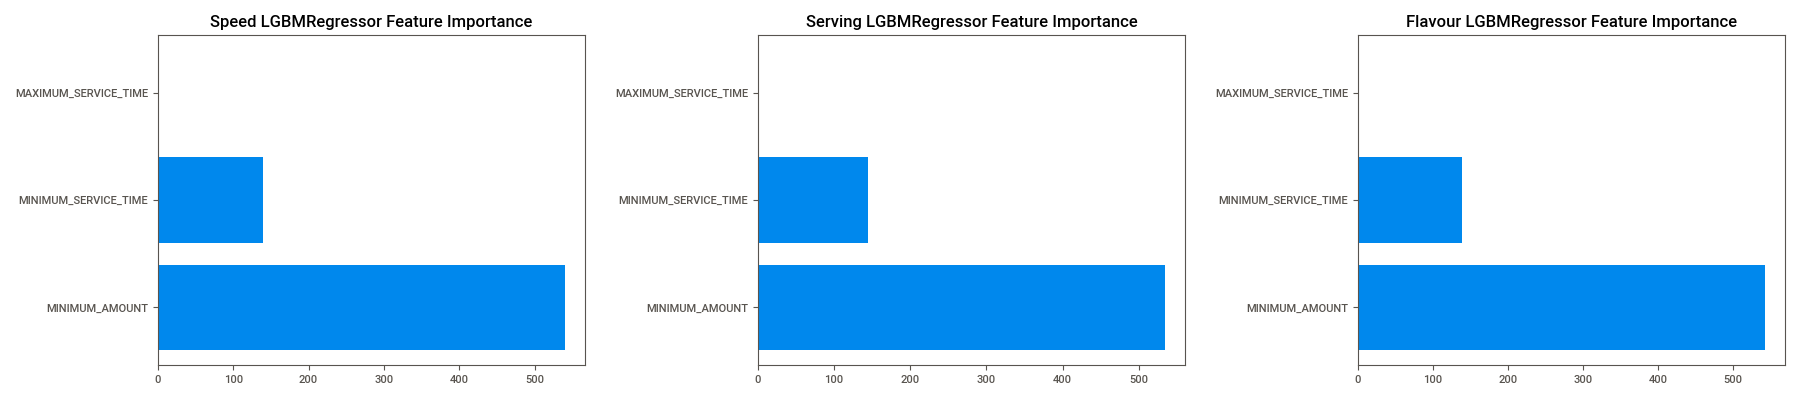

In [42]:
for label in ['SPEED','SERVING','FLAVOUR']:
    feature_columns = ['MINIMUM_AMOUNT','MINIMUM_SERVICE_TIME','MAXIMUM_SERVICE_TIME']
    model_name = "LGBMRegressor"
    not_null_df = service_df[pd.notnull(comment_df[label])]
    features = not_null_df[feature_columns].values
    labels = not_null_df[label].values

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/Service_{model_name}_{label}.mdl".format(label = label, model_name=model_name)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = LGBMRegressor(boosting_type='goss', n_jobs=-1, n_estimators=100, num_leaves=31, max_depth=-1, learning_rate=0.05, reg_alpha=0.0, reg_lambda=0.0)
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Mean Squared Error for {label}: {mse:0.2f}".format(mse  = mean_squared_error(labels_test, label_prediction), label=label))
    print("R2 Score for {label}: {r2:0.4f}\n".format(r2  = r2_score(labels_test, label_prediction), label=label))
    feature_importance_plot(label, model_name, feature_columns, model.feature_importances_)

merge_images(['images/SPEED.png', 'images/SERVING.png', 'images/FLAVOUR.png'])

Mean Squared Error for SPEED: 0.35
R2 Score for SPEED: 0.4813

Mean Squared Error for SERVING: 0.48
R2 Score for SERVING: 0.5180

Mean Squared Error for FLAVOUR: 0.50
R2 Score for FLAVOUR: 0.5131



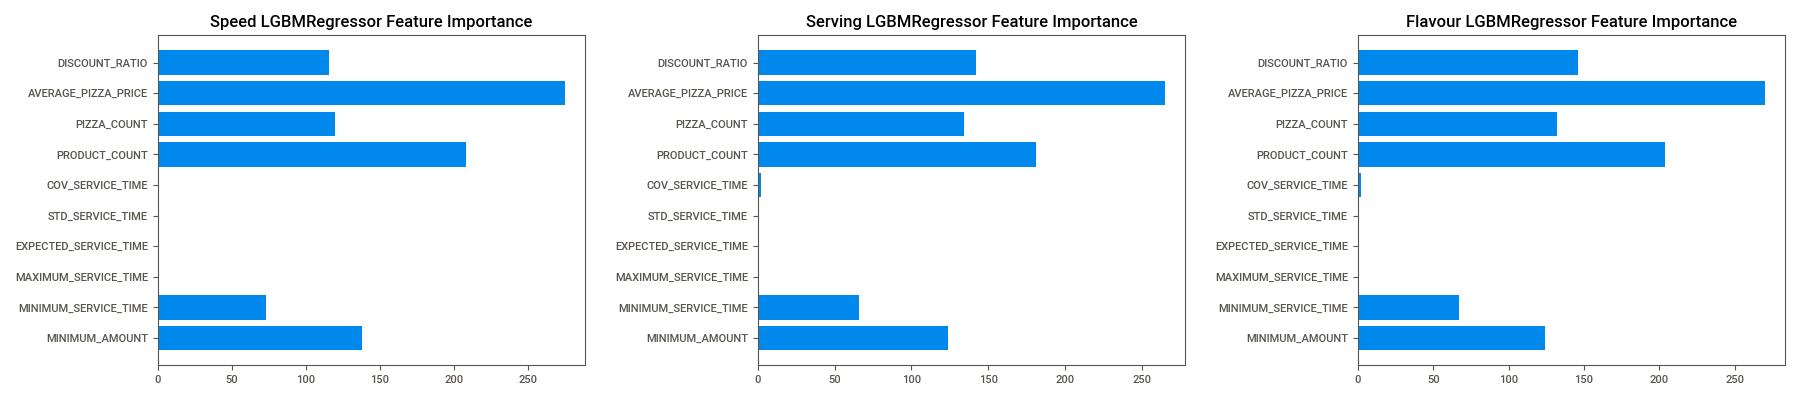

In [43]:
for label in ['SPEED','SERVING','FLAVOUR']:
    feature_columns = ['MINIMUM_AMOUNT','MINIMUM_SERVICE_TIME','MAXIMUM_SERVICE_TIME','EXPECTED_SERVICE_TIME','STD_SERVICE_TIME','COV_SERVICE_TIME','PRODUCT_COUNT','PIZZA_COUNT','AVERAGE_PIZZA_PRICE','DISCOUNT_RATIO']
    model_name = "LGBMRegressor"
    not_null_df = service_df[pd.notnull(service_df[label])]
    features = not_null_df[feature_columns].values
    labels = not_null_df[label].values

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/Service_Statistical_{model_name}_{label}.mdl".format(label = label, model_name=model_name)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = LGBMRegressor(boosting_type='goss', n_jobs=-1, n_estimators=100, num_leaves=31, max_depth=-1, learning_rate=0.05, reg_alpha=0.0, reg_lambda=0.0)
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)
    
    label_prediction = model.predict(features_test)

    print("Mean Squared Error for {label}: {mse:0.2f}".format(mse  = mean_squared_error(labels_test, label_prediction), label=label))
    print("R2 Score for {label}: {r2:0.4f}\n".format(r2  = r2_score(labels_test, label_prediction), label=label))
    feature_importance_plot(label, model_name, feature_columns, model.feature_importances_)

merge_images(['images/SPEED.png', 'images/SERVING.png', 'images/FLAVOUR.png'], background_color='WHITE')

Mean Squared Error for SPEED: 0.18
R2 Score for SPEED: 0.7310

Mean Squared Error for SERVING: 0.22
R2 Score for SERVING: 0.7773

Mean Squared Error for FLAVOUR: 0.23
R2 Score for FLAVOUR: 0.7778



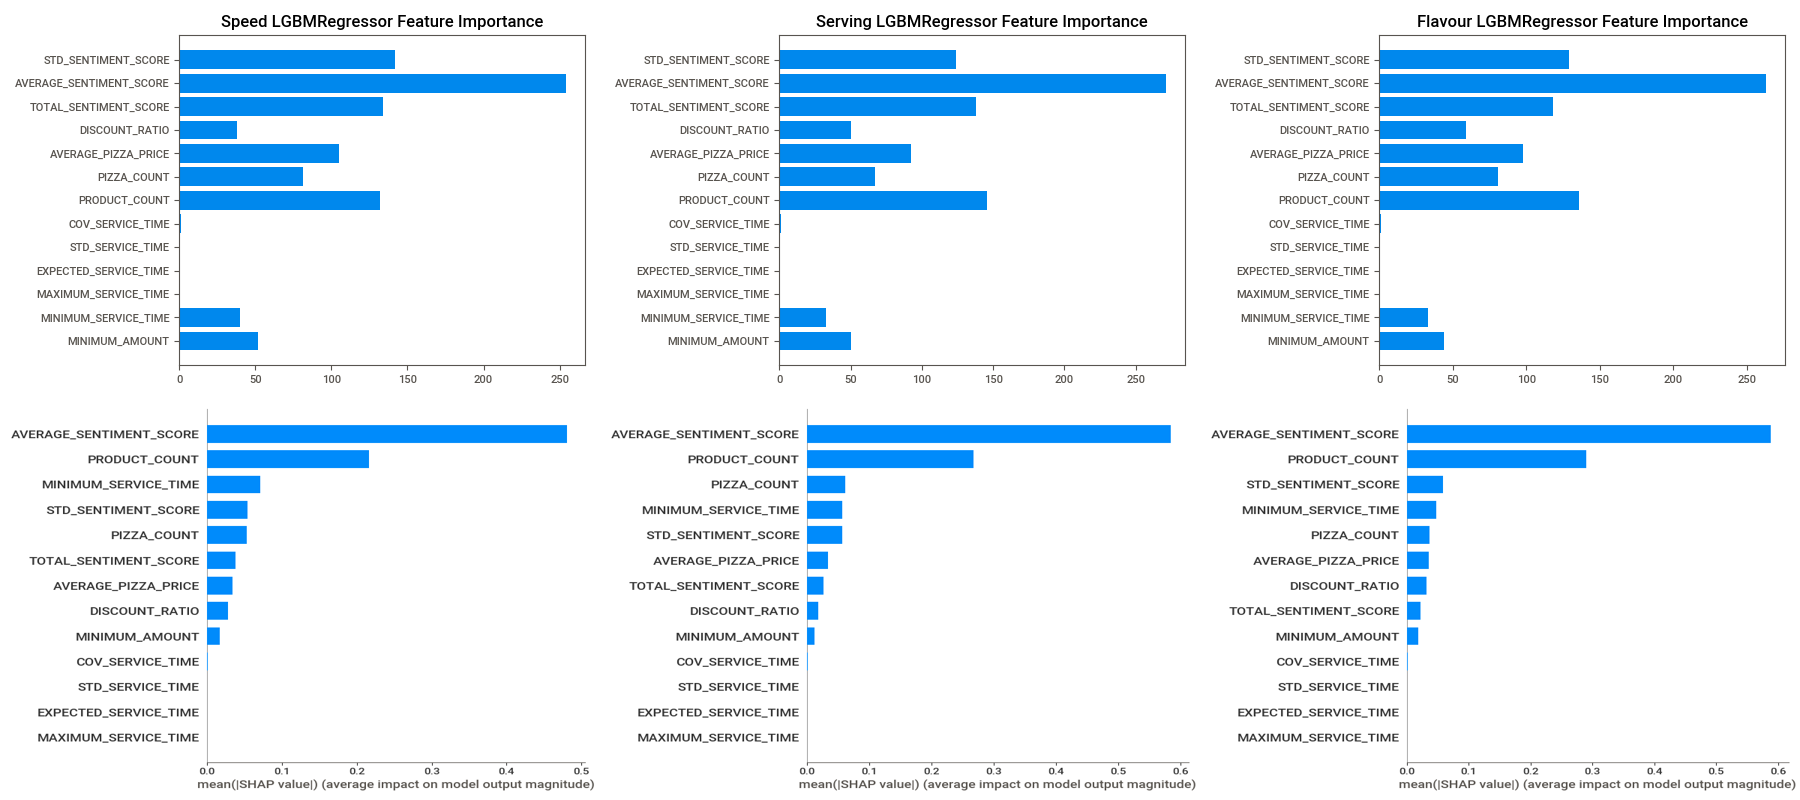

In [44]:
for label in ['SPEED','SERVING','FLAVOUR']:
    feature_columns = ['MINIMUM_AMOUNT', 'MINIMUM_SERVICE_TIME', 'MAXIMUM_SERVICE_TIME', 'EXPECTED_SERVICE_TIME', 'STD_SERVICE_TIME', 'COV_SERVICE_TIME', 'PRODUCT_COUNT', 'PIZZA_COUNT', 'AVERAGE_PIZZA_PRICE', 'DISCOUNT_RATIO', 'TOTAL_SENTIMENT_SCORE', 'AVERAGE_SENTIMENT_SCORE', 'STD_SENTIMENT_SCORE']
    model_name = "LGBMRegressor"
    not_null_df = service_df[pd.notnull(service_df[label])]
    features = not_null_df[feature_columns].values
    labels = not_null_df[label].values

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/Service_Sentiment_{model_name}_{label}.mdl".format(label = label, model_name=model_name)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = LGBMRegressor(boosting_type='goss', n_jobs=-1, n_estimators=100, num_leaves=31, max_depth=-1, learning_rate=0.05, reg_alpha=0.0, reg_lambda=0.0)
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Mean Squared Error for {label}: {mse:0.2f}".format(mse  = mean_squared_error(labels_test, label_prediction), label=label))
    print("R2 Score for {label}: {r2:0.4f}\n".format(r2  = r2_score(labels_test, label_prediction), label=label))
    feature_importance_plot(label, model_name, feature_columns, model.feature_importances_)
    shap_values = shap.TreeExplainer(model).shap_values(features_test, y=np.array(feature_columns))
    shap.summary_plot(shap_values, features_test, plot_type="bar", feature_names=feature_columns, show=False)
    plt.tight_layout()
    plt.autoscale()
    plt.savefig('images/SHAP_{label}.png'.format(label=label))
    plt.close()

merge_images([merge_images(['images/SPEED.png', 'images/SERVING.png', 'images/FLAVOUR.png'], background_color='WHITE'), merge_images(['images/SHAP_SPEED.png', 'images/SHAP_SERVING.png', 'images/SHAP_FLAVOUR.png'], background_color='WHITE')], orientation='vertical')

### XGBoost Regressor

In [45]:
for label in ['SPEED','SERVING','FLAVOUR']:
    not_null_df = service_df[pd.notnull(comment_df[label])]
    features = not_null_df[['MINIMUM_AMOUNT','MINIMUM_SERVICE_TIME','MAXIMUM_SERVICE_TIME']].values
    labels = not_null_df[label].values

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/Service_XGBRegressor_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = XGBRegressor()
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Mean Squared Error for {label}: {mse:0.2f}".format(mse  = mean_squared_error(labels_test, label_prediction), label=label))
    print("R2 Score for {label}: {r2:0.4f}\n".format(r2  = r2_score(labels_test, label_prediction), label=label))

Mean Squared Error for SPEED: 0.36
R2 Score for SPEED: 0.4697

Mean Squared Error for SERVING: 0.49
R2 Score for SERVING: 0.5016

Mean Squared Error for FLAVOUR: 0.51
R2 Score for FLAVOUR: 0.4996



### Stochastic Gradient Descent Regressor

In [46]:
for label in ['SPEED','SERVING','FLAVOUR']:
    not_null_df = service_df[pd.notnull(comment_df[label])]
    features = not_null_df[['MINIMUM_AMOUNT','MINIMUM_SERVICE_TIME','MAXIMUM_SERVICE_TIME']].values
    labels = not_null_df[label].values

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/Service_SGDRegressor_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = SGDRegressor(alpha=0.0001)
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Mean Squared Error for {label}: {mse:0.2f}".format(mse  = mean_squared_error(labels_test, label_prediction), label=label))
    print("R2 Score for {label}: {r2:0.4f}\n".format(r2  = r2_score(labels_test, label_prediction), label=label))

Mean Squared Error for SPEED: 764.54
R2 Score for SPEED: -1135.3673

Mean Squared Error for SERVING: 2323.84
R2 Score for SERVING: -2348.4848

Mean Squared Error for FLAVOUR: 827104.79
R2 Score for FLAVOUR: -813413.6787



### Kernel Ridge Regression

In [47]:
for label in ['SPEED','SERVING','FLAVOUR']:
    not_null_df = service_df[pd.notnull(comment_df[label])]
    features = not_null_df[['MINIMUM_AMOUNT','MINIMUM_SERVICE_TIME','MAXIMUM_SERVICE_TIME']].values
    labels = not_null_df[label].values

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/Service_KernelRidge_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = KernelRidge(kernel='polynomial', alpha=1, degree=5, coef0=1)
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Mean Squared Error for {label}: {mse:0.2f}".format(mse  = mean_squared_error(labels_test, label_prediction), label=label))
    print("R2 Score for {label}: {r2:0.4f}\n".format(r2  = r2_score(labels_test, label_prediction), label=label))

Mean Squared Error for SPEED: 0.54
R2 Score for SPEED: 0.1988

Mean Squared Error for SERVING: 0.78
R2 Score for SERVING: 0.2133

Mean Squared Error for FLAVOUR: 0.81
R2 Score for FLAVOUR: 0.2021



### ElasticNet Regression

In [48]:
for label in ['SPEED','SERVING','FLAVOUR']:
    not_null_df = service_df[pd.notnull(comment_df[label])]
    features = not_null_df[['MINIMUM_AMOUNT','MINIMUM_SERVICE_TIME','MAXIMUM_SERVICE_TIME']].values
    labels = not_null_df[label].values

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/Service_ElasticNet_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = ElasticNet(normalize=True)
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Mean Squared Error for {label}: {mse:0.2f}".format(mse  = mean_squared_error(labels_test, label_prediction), label=label))
    print("R2 Score for {label}: {r2:0.4f}\n".format(r2  = r2_score(labels_test, label_prediction), label=label))

Mean Squared Error for SPEED: 0.67
R2 Score for SPEED: -0.0031

Mean Squared Error for SERVING: 0.99
R2 Score for SERVING: -0.0005

Mean Squared Error for FLAVOUR: 1.02
R2 Score for FLAVOUR: -0.0004



### Bayesian Ridge Regression

In [49]:
for label in ['SPEED','SERVING','FLAVOUR']:
    not_null_df = service_df[pd.notnull(comment_df[label])]
    features = not_null_df[['MINIMUM_AMOUNT','MINIMUM_SERVICE_TIME','MAXIMUM_SERVICE_TIME']].values
    labels = not_null_df[label].values

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/Service_BayesianRidge_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = BayesianRidge(normalize=True)
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Mean Squared Error for {label}: {mse:0.2f}".format(mse  = mean_squared_error(labels_test, label_prediction), label=label))
    print("R2 Score for {label}: {r2:0.4f}\n".format(r2  = r2_score(labels_test, label_prediction), label=label))

Mean Squared Error for SPEED: 0.67
R2 Score for SPEED: 0.0036

Mean Squared Error for SERVING: 0.98
R2 Score for SERVING: 0.0070

Mean Squared Error for FLAVOUR: 1.01
R2 Score for FLAVOUR: 0.0067



### Gradient Boosting Regressor

In [50]:
for label in ['SPEED','SERVING','FLAVOUR']:
    not_null_df = service_df[pd.notnull(comment_df[label])]
    features = not_null_df[['MINIMUM_AMOUNT','MINIMUM_SERVICE_TIME','MAXIMUM_SERVICE_TIME']].values
    labels = not_null_df[label].values

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/Service_GradientBoostingRegressor_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = GradientBoostingRegressor(loss='ls', n_estimators=50, min_samples_split=20, min_samples_leaf=5, max_depth=3)
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Mean Squared Error for {label}: {mse:0.2f}".format(mse  = mean_squared_error(labels_test, label_prediction), label=label))
    print("R2 Score for {label}: {r2:0.4f}\n".format(r2  = r2_score(labels_test, label_prediction), label=label))

Mean Squared Error for SPEED: 0.37
R2 Score for SPEED: 0.4478

Mean Squared Error for SERVING: 0.51
R2 Score for SERVING: 0.4811

Mean Squared Error for FLAVOUR: 0.53
R2 Score for FLAVOUR: 0.4817



### Epsilon-Support Vector Regression

In [51]:
for label in ['SPEED','SERVING','FLAVOUR']:
    not_null_df = service_df[pd.notnull(comment_df[label])]
    features = not_null_df[['MINIMUM_AMOUNT','MINIMUM_SERVICE_TIME','MAXIMUM_SERVICE_TIME']].values
    labels = not_null_df[label].values

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)
    
    model_file_name = "models/Service_SVR_{label}.mdl".format(label = label)
    
    if(check_if_file_exists(model_file_name)):
        model = joblib.load(model_file_name)
    else:
        model = SVR(kernel='rbf')
        model.fit(features_train, labels_train)

        joblib.dump(model, model_file_name)

    label_prediction = model.predict(features_test)

    print("Mean Squared Error for {label}: {mse:0.2f}".format(mse  = mean_squared_error(labels_test, label_prediction), label=label))
    print("R2 Score for {label}: {r2:0.4f}\n".format(r2  = r2_score(labels_test, label_prediction), label=label))

Mean Squared Error for SPEED: 0.55
R2 Score for SPEED: 0.1761

Mean Squared Error for SERVING: 0.80
R2 Score for SERVING: 0.1872

Mean Squared Error for FLAVOUR: 0.84
R2 Score for FLAVOUR: 0.1771



## Clustering

In [52]:
sql_command = """
    WITH EFM AS(
    SELECT DISTINCT
    EFM."CATEGORY_NAME",
    EFM."PRODUCT_NAME",
    EFM."PRODUCT_DESCRIPTION",
    EFM."PRODUCT_LISTED_PRICE",
    EFM."PRODUCT_PRICE",
    EFM."DISCOUNT"
    FROM "EDW"."DWH_FB_MENU" EFM
    WHERE 1=1
    AND CASE WHEN LOWER(EFM."CATEGORY_NAME") LIKE '%pizza%' OR LOWER(EFM."PRODUCT_NAME") LIKE '%pizza%' OR LOWER(EFM."PRODUCT_DESCRIPTION") LIKE '%pizza%' THEN 1 ELSE 0 END = 1
    AND LOWER(EFM."CATEGORY_NAME") NOT LIKE '%soslar%' AND LOWER(EFM."CATEGORY_NAME") NOT LIKE '%yan %'
    ),
    QUARTILES AS(
    SELECT
    PERCENTILE_CONT(0.25) WITHIN GROUP(ORDER BY EFM."PRODUCT_LISTED_PRICE") AS Q1,
    PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY EFM."PRODUCT_LISTED_PRICE") AS Q2,
    PERCENTILE_CONT(0.75) WITHIN GROUP(ORDER BY EFM."PRODUCT_LISTED_PRICE") AS Q3
    FROM EFM
    ),
    OUTLIER_RANGES AS(
    SELECT 
    QR.Q1,
    QR.Q2,
    QR.Q3,
    QR.Q3-QR.Q1 AS IQR,
    QR.Q1-(1.5*(QR.Q3-QR.Q1)) AS MINIMA,
    QR.Q3+(1.5*(QR.Q3-QR.Q1)) AS MAXIMA
    FROM QUARTILES QR
    ),
    PIZZAS AS(
    SELECT * 
    FROM EFM
    INNER JOIN OUTLIER_RANGES ORA ON (1=1)
    WHERE EFM."PRODUCT_LISTED_PRICE" BETWEEN ORA.MINIMA AND ORA.MAXIMA
    ORDER BY EFM."PRODUCT_LISTED_PRICE"
    )
    SELECT 
    EFM.*,
    PIZ.Q1,
    PIZ.Q2,
    PIZ.Q3,
    PIZ.IQR,
    PIZ.MINIMA,
    PIZ.MAXIMA
    FROM "EDW"."DWH_FB_MENU" EFM
    INNER JOIN PIZZAS PIZ ON (EFM."CATEGORY_NAME" = PIZ."CATEGORY_NAME" AND EFM."PRODUCT_NAME" = PIZ."PRODUCT_NAME" AND EFM."PRODUCT_DESCRIPTION" = PIZ."PRODUCT_DESCRIPTION" AND EFM."PRODUCT_LISTED_PRICE" = PIZ."PRODUCT_LISTED_PRICE");
"""
menu_df = pd.read_sql(sql_command,conn)
menu_df.head()

PRODUCT_ID  \
0  4F9A1222-2174-4794-85BE-78B864137B58   
1  8b503b63-b162-4b43-a58c-301a41c6b98a   
2  15cff837-c4f5-4ded-b09e-dd8c6fd5e591   
3  ef08f896-366b-40b0-9858-6cdc69401f41   
4  e7e2b046-6d7b-4636-bcd7-59be32110798   

                                       RESTAURANT_ID  \
0  pizza-dante-sisli-ergenekon-mah-pangalti-istanbul   
1  pizza-dante-sisli-ergenekon-mah-pangalti-istanbul   
2  pizza-dante-sisli-ergenekon-mah-pangalti-istanbul   
3  pizza-dante-sisli-ergenekon-mah-pangalti-istanbul   
4  pizza-dante-sisli-ergenekon-mah-pangalti-istanbul   

                        CATEGORY_NAME  \
0                   Vodafone Menüleri   
1  Klasik & Sebzeli Pizzalar (25 cm.)   
2  Klasik & Sebzeli Pizzalar (25 cm.)   
3  Klasik & Sebzeli Pizzalar (25 cm.)   
4  Klasik & Sebzeli Pizzalar (25 cm.)   

                                 PRODUCT_NAME  \
0  Vodafone Menüsü (Pizza Refanzine (32 cm.))   
1                       Pizza Rucola (25 cm.)   
2                       Pizza Funghi (25 cm.)   
3             Pizza Quattro Formaggi (25 cm.)   
4                 Pizza Mediterraneo (25 cm.)   

                                 PRODUCT_DESCRIPTION  PRODUCT_LISTED_PRICE  \
0  Pizza Refanzine (32 cm.) + Coca-Cola (33 cl.) ...                  52.0   
1  Dante sos, mozzarella peyniri, roka, cherry do...                  66.0   
2      Dante sos, mozzarella peyniri, kültür mantarı                  58.0   
3  Dante sos, mozzarella peyniri, parmesan peynir...                  76.0   
4  Dante sos, mozzarella peyniri, beyaz peynir, y...                  66.0   

   PRODUCT_PRICE  DISCOUNT DESIGN_TYPE        DATE    q1    q2    q3   iqr  \
0           52.0     False        list  2021-06-03  36.9  47.0  61.0  24.1   
1           33.0      True        list  2021-06-03  36.9  47.0  61.0  24.1   
2           29.0      True        list  2021-06-03  36.9  47.0  61.0  24.1   
3           38.0      True        list  2021-06-03  36.9  47.0  61.0  24.1   
4           33.0      True        list  2021-06-03  36.9  47.0  61.0  24.1   

   minima  maxima  
0    0.75   97.15  
1    0.75   97.15  
2    0.75   97.15  
3    0.75   97.15  
4    0.75   97.15

In [53]:
sql_command = """
    WITH EFM AS(
    SELECT DISTINCT
    EFM."CATEGORY_NAME",
    EFM."PRODUCT_NAME",
    EFM."PRODUCT_DESCRIPTION",
    EFM."PRODUCT_LISTED_PRICE",
    EFM."PRODUCT_PRICE",
    EFM."DISCOUNT"
    FROM "EDW"."DWH_FB_MENU" EFM
    WHERE 1=1
    AND CASE WHEN LOWER(EFM."CATEGORY_NAME") LIKE '%pizza%' OR LOWER(EFM."PRODUCT_NAME") LIKE '%pizza%' OR LOWER(EFM."PRODUCT_DESCRIPTION") LIKE '%pizza%' THEN 1 ELSE 0 END = 1
    AND LOWER(EFM."CATEGORY_NAME") NOT LIKE '%soslar%' AND LOWER(EFM."CATEGORY_NAME") NOT LIKE '%yan %'
    ),
    QUARTILES AS(
    SELECT
    PERCENTILE_CONT(0.25) WITHIN GROUP(ORDER BY EFM."PRODUCT_LISTED_PRICE") AS Q1,
    PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY EFM."PRODUCT_LISTED_PRICE") AS Q2,
    PERCENTILE_CONT(0.75) WITHIN GROUP(ORDER BY EFM."PRODUCT_LISTED_PRICE") AS Q3
    FROM EFM
    ),
    OUTLIER_RANGES AS(
    SELECT 
    QR.Q1,
    QR.Q2,
    QR.Q3,
    QR.Q3-QR.Q1 AS IQR,
    QR.Q1-(1.5*(QR.Q3-QR.Q1)) AS MINIMA,
    QR.Q3+(1.5*(QR.Q3-QR.Q1)) AS MAXIMA
    FROM QUARTILES QR
    ),
    PIZZAS AS(
    SELECT * 
    FROM EFM
    INNER JOIN OUTLIER_RANGES ORA ON (1=1)
    WHERE EFM."PRODUCT_LISTED_PRICE" BETWEEN ORA.MINIMA AND ORA.MAXIMA
    ORDER BY EFM."PRODUCT_LISTED_PRICE"
    )
    SELECT 
    EFM."RESTAURANT_ID",
    AVG(EFM."PRODUCT_LISTED_PRICE") AS "AVERAGE_PRODUCT_LISTED_PRICE",
    COUNT(*) AS "NUMBER_OF_PRODUCTS"
    FROM "EDW"."DWH_FB_MENU" EFM
    INNER JOIN PIZZAS PIZ ON (EFM."CATEGORY_NAME" = PIZ."CATEGORY_NAME" AND EFM."PRODUCT_NAME" = PIZ."PRODUCT_NAME" AND EFM."PRODUCT_DESCRIPTION" = PIZ."PRODUCT_DESCRIPTION" AND EFM."PRODUCT_LISTED_PRICE" = PIZ."PRODUCT_LISTED_PRICE")
    GROUP BY EFM."RESTAURANT_ID";
"""
restaurant_df = pd.read_sql(sql_command,conn)
restaurant_df.head()

RESTAURANT_ID  \
0  1991-tarihi-ortakoy-kumpircisi-silivri-yeni-ma...   
1           400-c-pizza-sisli-tesvikiye-mah-istanbul   
2         400-c-pizza-umraniye-serifali-mah-istanbul   
3          444-pizza-bagcilar-demirkapi-mah-istanbul   
4            444-pizza-eyup-emniyettepe-mah-istanbul   

   AVERAGE_PRODUCT_LISTED_PRICE  NUMBER_OF_PRODUCTS  
0                     41.600000                  10  
1                     62.042553                  47  
2                     63.476190                  42  
3                     43.163793                  58  
4                     43.818462                  65

### K-Means Clustering

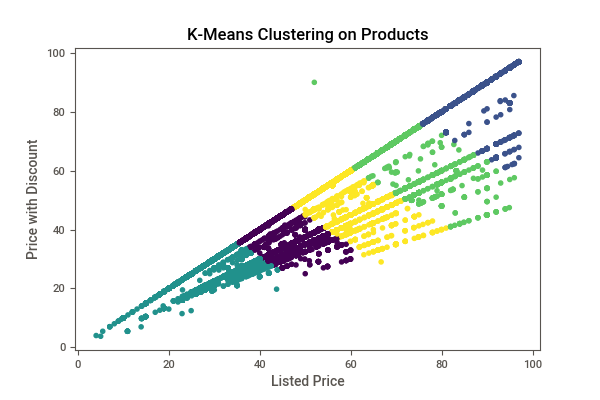

In [54]:
if not(check_if_file_exists('images/kmeans_product_cluster.png')):
    model = KMeans(n_clusters=5).fit(menu_df[["PRODUCT_LISTED_PRICE","PRODUCT_PRICE"]].values)
    labels = model.predict(menu_df[["PRODUCT_LISTED_PRICE","PRODUCT_PRICE"]].values)
    plt.scatter(menu_df["PRODUCT_LISTED_PRICE"].values,menu_df["PRODUCT_PRICE"].values,c=labels, cmap='viridis');
    plt.xlabel("Listed Price")
    plt.ylabel("Price with Discount")
    plt.title('K-Means Clustering on Products')
    plt.savefig('images/kmeans_product_cluster.png')
    plt.close()
Image.open('images/kmeans_product_cluster.png')

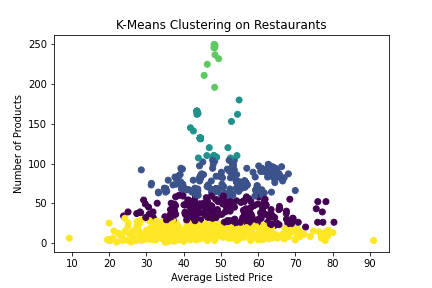

In [55]:
if not(check_if_file_exists('images/kmeans_restaurant_cluster.png')):
    model = KMeans(n_clusters=5).fit(restaurant_df[["AVERAGE_PRODUCT_LISTED_PRICE","NUMBER_OF_PRODUCTS"]].values)
    labels = model.predict(restaurant_df[["AVERAGE_PRODUCT_LISTED_PRICE","NUMBER_OF_PRODUCTS"]].values)
    plt.scatter(restaurant_df["AVERAGE_PRODUCT_LISTED_PRICE"].values,restaurant_df["NUMBER_OF_PRODUCTS"].values,c=labels, cmap='viridis');
    plt.xlabel("Average Listed Price")
    plt.ylabel("Number of Products")
    plt.title('K-Means Clustering on Restaurants')
    plt.savefig('images/kmeans_restaurant_cluster.png')
    plt.close()
Image.open('images/kmeans_restaurant_cluster.png')

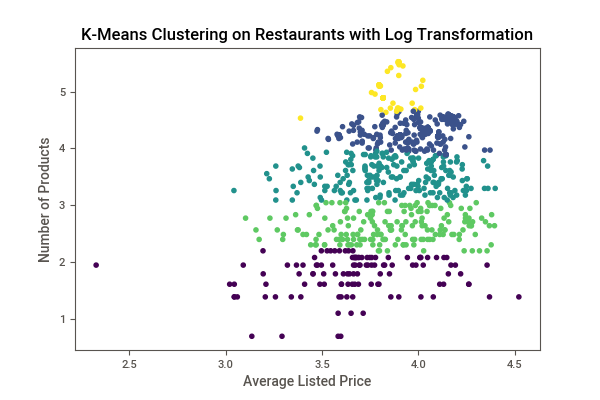

In [56]:
if not(check_if_file_exists('images/kmeans_log_restaurant_cluster.png')):
    temp_df = np.log(restaurant_df[["AVERAGE_PRODUCT_LISTED_PRICE","NUMBER_OF_PRODUCTS"]]+1)
    model = KMeans(n_clusters=5).fit(temp_df[["AVERAGE_PRODUCT_LISTED_PRICE","NUMBER_OF_PRODUCTS"]].values)
    labels = model.predict(temp_df[["AVERAGE_PRODUCT_LISTED_PRICE","NUMBER_OF_PRODUCTS"]].values)
    plt.scatter(temp_df["AVERAGE_PRODUCT_LISTED_PRICE"].values,temp_df["NUMBER_OF_PRODUCTS"].values,c=labels, cmap='viridis');
    plt.xlabel("Average Listed Price")
    plt.ylabel("Number of Products")
    plt.title('K-Means Clustering on Restaurants with Log Transformation')
    plt.savefig('images/kmeans_log_restaurant_cluster.png')
    plt.close()
Image.open('images/kmeans_log_restaurant_cluster.png')

### Gaussian Mixture Models

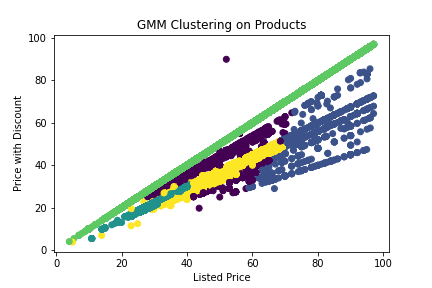

In [57]:
if not(check_if_file_exists('images/gmm_product_cluster.png')):
    model = mixture.GaussianMixture(n_components=5).fit(menu_df[["PRODUCT_LISTED_PRICE","PRODUCT_PRICE"]].values)
    labels = model.predict(menu_df[["PRODUCT_LISTED_PRICE","PRODUCT_PRICE"]].values)
    plt.scatter(menu_df["PRODUCT_LISTED_PRICE"].values,menu_df["PRODUCT_PRICE"].values,c=labels, cmap='viridis');
    plt.xlabel("Listed Price")
    plt.ylabel("Price with Discount")
    plt.title('GMM Clustering on Products')
    plt.savefig('images/gmm_product_cluster.png')
    plt.close()
Image.open('images/gmm_product_cluster.png')

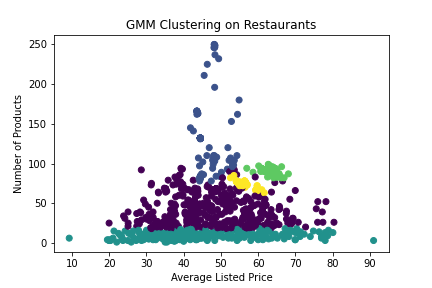

In [58]:
if not(check_if_file_exists('images/gmm_restaurant_cluster.png')):
    model = mixture.GaussianMixture(n_components=5).fit(restaurant_df[["AVERAGE_PRODUCT_LISTED_PRICE","NUMBER_OF_PRODUCTS"]].values)
    labels = model.predict(restaurant_df[["AVERAGE_PRODUCT_LISTED_PRICE","NUMBER_OF_PRODUCTS"]].values)
    plt.scatter(restaurant_df["AVERAGE_PRODUCT_LISTED_PRICE"].values,restaurant_df["NUMBER_OF_PRODUCTS"].values,c=labels, cmap='viridis');
    plt.xlabel("Average Listed Price")
    plt.ylabel("Number of Products")
    plt.title('GMM Clustering on Restaurants')
    plt.savefig('images/gmm_restaurant_cluster.png')
    plt.close()
Image.open('images/gmm_restaurant_cluster.png')

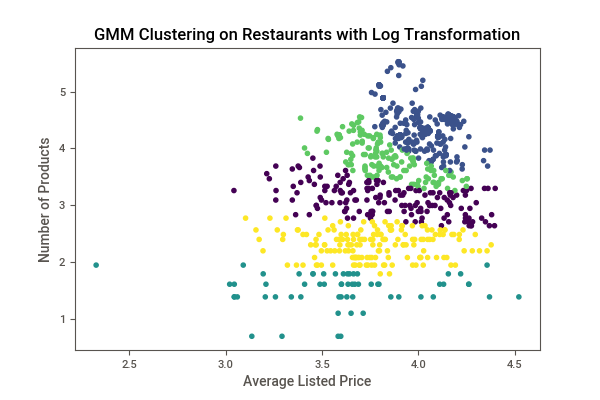

In [59]:
if not(check_if_file_exists('images/gmm_log_restaurant_cluster.png')):
    temp_df = np.log(restaurant_df[["AVERAGE_PRODUCT_LISTED_PRICE","NUMBER_OF_PRODUCTS"]]+1)
    model = mixture.GaussianMixture(n_components=5).fit(temp_df[["AVERAGE_PRODUCT_LISTED_PRICE","NUMBER_OF_PRODUCTS"]].values)
    labels = model.predict(temp_df[["AVERAGE_PRODUCT_LISTED_PRICE","NUMBER_OF_PRODUCTS"]].values)
    plt.scatter(temp_df["AVERAGE_PRODUCT_LISTED_PRICE"].values,temp_df["NUMBER_OF_PRODUCTS"].values,c=labels, cmap='viridis');
    plt.xlabel("Average Listed Price")
    plt.ylabel("Number of Products")
    plt.title('GMM Clustering on Restaurants with Log Transformation')
    plt.savefig('images/gmm_log_restaurant_cluster.png')
    plt.close()
Image.open('images/gmm_log_restaurant_cluster.png')

## Markov Chains

Markov chains calculate how frequently words follow each other and generate new text depending on the first words we are given. These models can be used to create fake reviews.

In [60]:
sql_command = """
    WITH COMMENTS AS(
    SELECT "RESTAURANT_ID",
    STRING_AGG(LOWER("COMMENT_TEXT"), ' ') AS ALL_COMMENT,
    COUNT("COMMENT_TEXT") AS COMMENT_COUNT
    FROM "ODS"."EXT_FB_COMMENT" EFC
    GROUP BY "RESTAURANT_ID"
    )
    SELECT * 
    FROM COMMENTS
    ORDER BY COMMENT_COUNT DESC;
    """
restaurant_df = pd.read_sql(sql_command,conn)
restaurant_df.head()

RESTAURANT_ID  \
0    pizza-bulls-uskudar-altunizade-mah-istanbul   
1         pizza-bulls-uskudar-ferah-mah-istanbul   
2  pizza-bulls-kartal-soganlik-yeni-mah-istanbul   
3       pizza-bulls-umraniye-cakmak-mah-istanbul   
4        pizza-bulls-atasehir-fetih-mah-istanbul   

                                         all_comment  comment_count  
0  lezzeti eskisi gibi gelmedi bize. fark ödeyip ...           2293  
1  her şey çok güzeldi. elinize sağlık. hizli ve ...           1764  
2  cok pahali olmasi disinda bir problem yok gibi...           1743  
3  çok lezzetli güvenle çoçuguma yedirebiliyorum ...           1582  
4  servis ve hız 10 üzerinden 20.. bu siparişi is...           1277

In [61]:
import random

def make_markov_model(cleaned_stories, n_gram=2):
    markov_model = {}
    for i in range(len(cleaned_stories)-n_gram-1):
        curr_state, next_state = "", ""
        for j in range(n_gram):
            curr_state += cleaned_stories[i+j] + " "
            next_state += cleaned_stories[i+j+n_gram] + " "
        curr_state = curr_state[:-1]
        next_state = next_state[:-1]
        if curr_state not in markov_model:
            markov_model[curr_state] = {}
            markov_model[curr_state][next_state] = 1
        else:
            if next_state in markov_model[curr_state]:
                markov_model[curr_state][next_state] += 1
            else:
                markov_model[curr_state][next_state] = 1
    
    # calculating transition probabilities
    for curr_state, transition in markov_model.items():
        total = sum(transition.values())
        for state, count in transition.items():
            markov_model[curr_state][state] = count/total
        
    return markov_model

def generate_story(markov_model, limit=100, start='my god'):
    n = 0
    curr_state = start
    next_state = None
    story = ""
    story+=curr_state+" "
    while n<limit:
        next_state = random.choices(list(markov_model[curr_state].keys()),
                                    list(markov_model[curr_state].values()))
        
        curr_state = next_state[0]
        story+=curr_state+" "
        n+=1
    return story

In [62]:
restaurant_df['clean_comment'] = restaurant_df['all_comment'].apply(clean_text)
text = restaurant_df.loc[0]['clean_comment'].split()

markov_model = make_markov_model(text)

for i in range(20):
    print(str(i)+". ", generate_story(markov_model, start="yemek çok", limit=20))

0.  yemek çok lezzetliydi ve kurye de cok nazikti semih beye sufle ikramından dolayı çok teşekkürler yine sıcacık getirdi emek ve özeninden dolayı kendisini tebrik ederim pizza lezizdi her zamanki gibi çok güzeldi ayrıca atakan beye tatlı ikramı içinde teşekkür ederim lezzet her 
1.  yemek çok güzeldi semih beye teşekkürler güzeldi teşekkürler her zamanki gibi hızlı ve lezzetli pizzalar emeğinize sağlık kurye atakan bey sürprizi için teşekkür ederiz sanitasyon koşullarına biraz daha mozarella olsa daha da sipariş vermem bullstan çok teşekkür ederiz hızlı gelmesi getiren arkadaşın 
2.  yemek çok güzeldi semih bey harikasınız maşallah size bize her zaman siz getirin ve sufle getirin mükemmel hizmet gayet hızlı bir siparişti sufle ikramında bulunmaları memnun etti çok teşekkür ederiz a bilal bey ikramlar için çok teşekkür ederiz bilal beye cok tesekkur 
3.  yemek çok lezzetliydi ve her şey harikaydı atakan beye teşekkürler suflemi getirmediniz bi daha asla suflenize bayılıyoruz gerçekten 

## Convolutional Neural Network

Convolutional neural networks are used for image classification purposes. For our labels, we are considering if a product name, description, or product category contains the word pizza in it or not.

In [63]:
sql_command = """
    SELECT
    DISTINCT
    FPI."IMAGE_LINK",
    FPIS."SOURCE",
    CASE WHEN LOWER(EFM."CATEGORY_NAME") LIKE '%pizza%' OR LOWER(EFM."PRODUCT_NAME") LIKE '%pizza%' OR LOWER(EFM."PRODUCT_DESCRIPTION") LIKE '%pizza%' THEN 1 ELSE 0 END AS "IS_PIZZA"
    FROM "ODS"."EXT_FB_MENU" EFM
    INNER JOIN "ODS"."EXT_FB_PRODUCT_IMAGE" FPI ON (EFM."PRODUCT_ID" = FPI."PRODUCT_ID")
    INNER JOIN "ODS"."EXT_FB_PRODUCT_IMAGE_SOURCE" FPIS ON (FPI."IMAGE_LINK" = FPIS."IMAGE_LINK");
    """
image_source_df = pd.read_sql(sql_command,conn)
image_source_df

IMAGE_LINK  \
0     https://cdn.yemeksepeti.com/ProductImages/corb...   
1     https://cdn.yemeksepeti.com/ProductImages/corb...   
2     https://cdn.yemeksepeti.com/ProductImages/corb...   
3     https://cdn.yemeksepeti.com/ProductImages/corb...   
4     https://cdn.yemeksepeti.com/ProductImages/corb...   
...                                                 ...   
4961  https://cdn.yemeksepeti.com/restaurant/TR_ISTA...   
4962  https://cdn.yemeksepeti.com/restaurant/TR_ISTA...   
4963  https://cdn.yemeksepeti.com/restaurant/TR_ISTA...   
4964  https://cdn.yemeksepeti.com/restaurant/TR_ISTA...   
4965  https://cdn.yemeksepeti.com/restaurant/TR_ISTA...   

                                                 SOURCE  IS_PIZZA  
0     [b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...         0  
1     [b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...         0  
2     [b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...         0  
3     [b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...         0  
4     [b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...         0  
...                                                 ...       ...  
4961  [b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...         1  
4962  [b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...         0  
4963  [b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...         1  
4964  [b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...         1  
4965  [b'\xff', b'\xd8', b'\xff', b'\xe0', b'\x00', ...         0  

[4966 rows x 3 columns]

In [64]:
features = []
labels = []

for i in range(len(image_source_df)):
    image_source = byte_image_to_numpy_array(image_source_df.iloc[i]["SOURCE"], 200)
    is_pizza = image_source_df.iloc[i]["IS_PIZZA"]
    features.append(image_source)
    labels.append(is_pizza)

features = np.array(features).reshape(-1, 200, 200, 3)
features = features.astype('float32')/255
labels = np_utils.to_categorical(labels, 2)

batch_size = 16
epochs = 3

print("Feature Shape: {f_shape} Label Shape: {l_shape}".format(f_shape=features.shape, l_shape=labels.shape))

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 9)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2,  activation=tf.nn.softmax)
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(features_train, labels_train, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = (features_test, labels_test))
label_prediction = model.predict(features_test)
score = model.evaluate(features_test, labels_test, verbose = 0)
print("""Loss: {loss_score:0.4f} Accuracy: {accuracy:0.2f}%""".format(loss_score=score[0], accuracy=score[1]*100))

Feature Shape: (4966, 200, 200, 3) Label Shape: (4966, 2)
Epoch 1/3
 47/218 [=====>........................] - ETA: 1:20 - loss: 0.9864 - accuracy: 0.6263

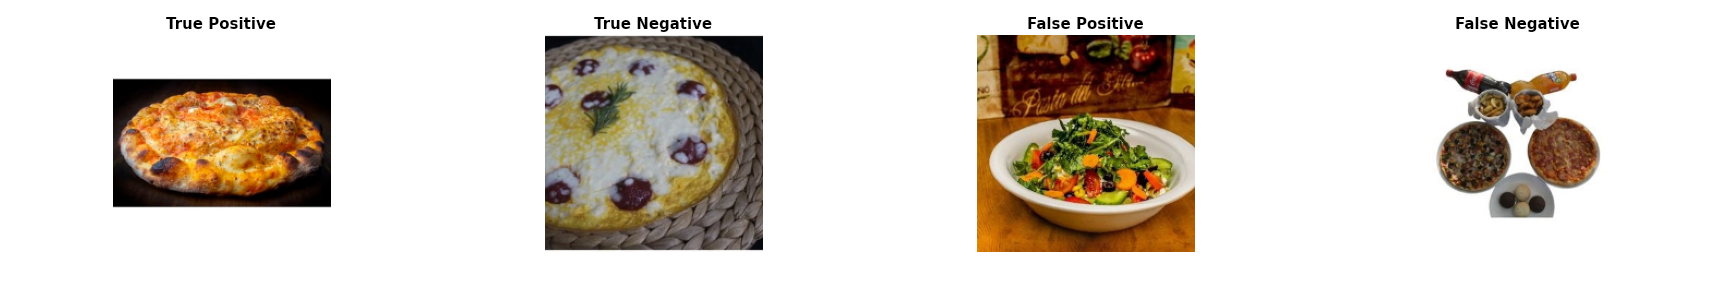

In [ ]:
if(not(check_if_file_exists('images/cnn_tp.png') and check_if_file_exists('images/cnn_tn.png') and check_if_file_exists('images/cnn_fp.png') and check_if_file_exists('images/cnn_fn.png'))):
    tp, tn, fp, fn = False, False, False, False
    for test_row in range(len(labels_test)):
        true_label = labels_test[test_row][1].astype(np.uint8)
        prediction = round(label_prediction[test_row][1])
        if(true_label == 1 and prediction == 1 and tp == False):
            tp = test_row
            plt.title('True Positive',fontweight='bold',fontsize=15)
            plt.imshow((features_test[tp]*255).astype(np.uint8))
            plt.axis('off')
            plt.savefig('images/cnn_tp.png')
            plt.close()
            continue
        if(true_label == 0 and prediction == 0 and tn == False):
            tn = test_row
            plt.title('True Negative',fontweight='bold',fontsize=15)
            plt.imshow((features_test[tn]*255).astype(np.uint8))
            plt.axis('off')
            plt.savefig('images/cnn_tn.png')
            plt.close()
            continue
        if(true_label == 0 and prediction == 1 and fp == False):
            fp = test_row
            plt.title('False Positive',fontweight='bold',fontsize=15)
            plt.imshow((features_test[fp]*255).astype(np.uint8))
            plt.axis('off')
            plt.savefig('images/cnn_fp.png')
            plt.close()
            continue
        if(true_label == 1 and prediction == 0 and fn == False):
            fn = test_row
            plt.title('False Negative',fontweight='bold',fontsize=15)
            plt.imshow((features_test[fn]*255).astype(np.uint8))
            plt.axis('off')
            plt.savefig('images/cnn_fn.png')
            plt.close()
            continue    

merge_images(['images/cnn_tp.png', 'images/cnn_tn.png', 'images/cnn_fp.png', 'images/cnn_fn.png'], background_color='WHITE')

# Sources

 1. [Selenium Documentation](https://selenium-python.readthedocs.io/)
 2. [Selenium choose element by partial id](https://stackoverflow.com/questions/15845563/choose-element-by-partial-id-using-selenium-with-python)
 3. [Selenium scroll down to end of the page](https://pythonbasics.org/selenium-scroll-down/)
 4. [Selenium click button](https://stackoverflow.com/questions/52405456/selenium-how-to-click-on-javascript-button/52405550)
 5. [Markov Chains](https://www.kaggle.com/orion99/markov-chain-nlp)
 6. [Bag of Words](https://github.com/Suji04/NormalizedNerd/blob/master/Introduction%20to%20NLP/Bag%20of%20Words%20%2B%20TF-IDF.ipynb)
 7. [Turkish Porter Stemmer](https://github.com/otuncelli/turkish-stemmer-python)
 8. [Scikit-Learn: Save & Restore Models](https://stackabuse.com/scikit-learn-save-and-restore-models)
 9. [Joblib vs Pickle](https://stackoverflow.com/questions/12615525/what-are-the-different-use-cases-of-joblib-versus-pickle)
 10. [Hide warnings in Python](https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython)
 11. [Slow scrolling down the page using selenium](https://stackoverflow.com/questions/30942041/slow-scrolling-down-the-page-using-selenium)
 12. [Download images using urllib](https://stackoverflow.com/questions/49627458/python-selenium-download-images-jpeg-png-or-pdf-using-chromedriver)
 13. [Saving an image to Postgres](https://stackoverflow.com/questions/16763904/how-to-save-a-image-file-on-a-postgres-database)
 14. [Convolutional Neural Networks](https://www.analyticsvidhya.com/blog/2021/01/image-classification-using-convolutional-neural-networks-a-step-by-step-guide/)
 15. [Combine several images](https://stackoverflow.com/questions/30227466/combine-several-images-horizontally-with-python)
 16. [Postgresql keeping only alphanumeric characters](https://stackoverflow.com/questions/4428645/postgres-regexp-replace-want-to-allow-only-a-z-and-a-z)
 17. [Sentiment Lexicons for 81 Languages](https://www.kaggle.com/rtatman/sentiment-lexicons-for-81-languages)
 18. [Replace transparency with a color in PIL](https://stackoverflow.com/questions/50898034/how-replace-transparent-with-a-color-in-pillow/50898375)
 19. [Distribution plot](https://stackoverflow.com/questions/51417483/mean-median-mode-lines-showing-only-in-last-graph-in-seaborn/51417635)